In [1]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet50, resnet152
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

import torch.nn.functional as F
from torchvision import transforms
import cv2
from PIL import Image

from torch.optim import AdamW

import matplotlib.pyplot as plt
import seaborn as sns

from enum import Enum

import os
import pickle
import random
import functools


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
proj_path = '.'
data_path = f'{proj_path}/MURA-v1.1'

# Load Dataset

In [5]:
# ALL Data
X_train = pd.read_csv(f'{data_path}/train_image_paths.csv', header=None, names=['filePath'])
y_train = pd.read_csv(f'{data_path}/train_labeled_studies.csv', names=['patientDir', 'label'])

X_val = pd.read_csv(f'{data_path}/valid_image_paths.csv', header=None, names=['filePath'])
y_val = pd.read_csv(f'{data_path}/valid_labeled_studies.csv', names=['patientDir', 'label'])

#### Verify loading

In [7]:
X_train.shape

(36808, 1)

In [8]:
X_train.head()

,filePath
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [9]:
X_train[:3]

,filePath
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...


The label is for a patient. (for all is XRays)

In [10]:
y_train.iloc[0, 0]

'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/'

In [11]:
y_train.iloc[:, 0]


0        MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1        MURA-v1.1/train/XR_SHOULDER/patient00002/study...
2        MURA-v1.1/train/XR_SHOULDER/patient00003/study...
3        MURA-v1.1/train/XR_SHOULDER/patient00004/study...
4        MURA-v1.1/train/XR_SHOULDER/patient00005/study...
                               ...                        
13452    MURA-v1.1/train/XR_HAND/patient11180/study1_ne...
13453    MURA-v1.1/train/XR_HAND/patient11181/study1_ne...
13454    MURA-v1.1/train/XR_HAND/patient11182/study1_ne...
13455    MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
13456    MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
Name: patientDir, Length: 13457, dtype: object

# Dataset description

In [12]:
print(f"# of patients: {y_train.shape[0]}")
print(f"# samples/ X-rays: {X_train.shape[0]}")
print()

labels, counts = np.unique(y_train['label'], return_counts=True)
print(f"# labels: {len(labels)}")
print(f"Non-fraction: {labels[0]}; Fraction Label: {labels[1]}")
print()

print(f"# patient with fraction: {counts[1]}")
print(f"# patient withOUT fraction: {counts[0]}")
print()

print(f"Proposion of positive (patients with fraction): {counts[1] / y_train.shape[0]:.3f}")


# of patients: 13457
# samples/ X-rays: 36808

# labels: 2
Non-fraction: 0; Fraction Label: 1

# patient with fraction: 5177
# patient withOUT fraction: 8280

Proposion of positive (patients with fraction): 0.385


In [13]:
np.unique(y_train['label'], return_counts=True)

(array([0, 1]), array([8280, 5177]))

In [14]:
def show_xr(xr_path):
    xr = cv2.imread(xr_path)
    plt.imshow(xr)
    plt.show()

def show_patient_images(patient_dir):
    path_to_patient = f'{proj_path}/{patient_dir}'
    xrs = os.listdir(path_to_patient)

    for xr in xrs:
        print(xr)
        show_xr(f'{path_to_patient}/{xr}')

#### Patient 1

image2.png


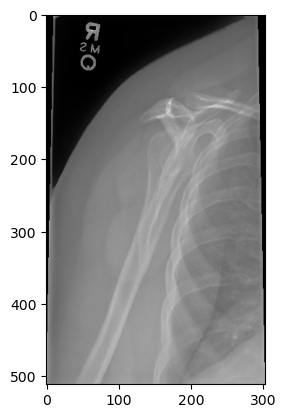

image1.png


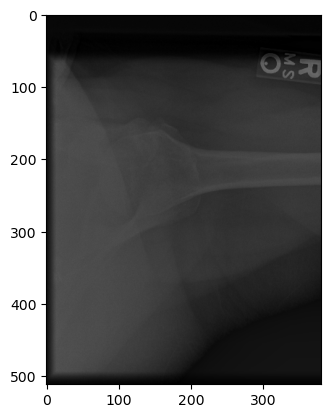

image3.png


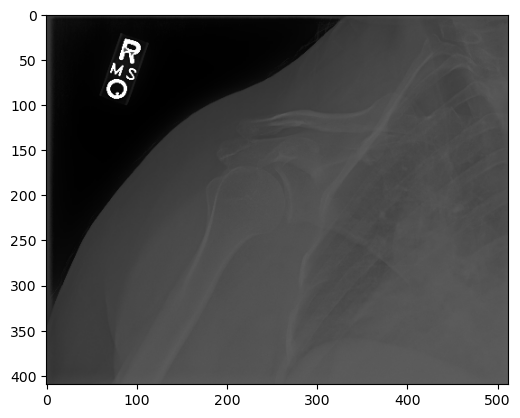

In [15]:
show_patient_images(y_train['patientDir'][0])

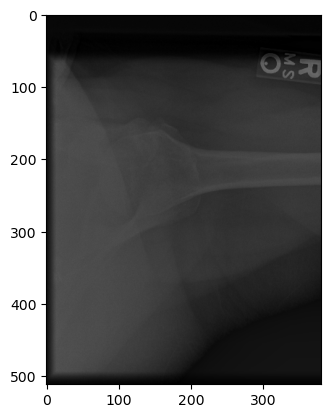

In [16]:
show_xr(X_train['filePath'][0])

In [17]:
def get_client_data(patient_path: str):
    res = []
    xr_names = os.listdir(patient_path)

    for xr in xr_names:
        xr_data = cv2.imread(f'{patient_path}/{xr}')
        res.append(xr_data)

    return res

# Preparation

In [6]:
type(X_train)

pandas.core.frame.DataFrame

In [6]:
X_train['Label'] = X_train['filePath'].apply(lambda x:1 if 'positive' in x else 0)
X_train['BodyPart'] = X_train['filePath'].apply(lambda x: x.split('/')[2][3:])
X_train['StudyType'] = X_train['filePath'].apply(lambda x: x.split('/')[4][:6])

X_val['Label'] = X_val['filePath'].apply(lambda x:1 if 'positive' in x else 0)
X_val['BodyPart'] = X_val['filePath'].apply(lambda x: x.split('/')[2][3:])
X_val['StudyType'] = X_val['filePath'].apply(lambda x: x.split('/')[4][:6])

X_train.set_index(["filePath", "BodyPart"]).count(level="BodyPart")
X_train.set_index(["filePath", "Label"]).count(level="Label")

,BodyPart,StudyType
Label,,
0,21935,21935
1,14873,14873


In [7]:
X_train.head()

,filePath,Label,BodyPart,StudyType
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1


In [7]:
np.unique(X_train['BodyPart'], return_counts=True)

(array(['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER',
        'WRIST'], dtype=object),
 array([4931, 5106, 1825, 5543, 1272, 8379, 9752]))

# Visualization

In [22]:
def compare_normal_and_abnormal(body_parts):
    images = {}
    fig, ax = plt.subplots(len(body_parts), 2, figsize=(8, 12))

    for i, body_part in enumerate(body_parts):
        df_part = X_train[X_train['BodyPart'] == body_part]
        fraction_sample = df_part[df_part['Label'] == 1].sample(1)
        normal_sample = df_part[df_part['Label'] == 0].sample(1)
        
        fraction_image_path = fraction_sample['filePath'].values[0]
        normal_image_path = normal_sample['filePath'].values[0]
        images[body_part] = (fraction_image_path, normal_image_path)
    
        ax[i, 0].imshow(cv2.imread(f'{proj_path}/{images[body_part][0]}'))
        ax[i, 0].set_title(f'Abnormal (Fraction)')
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].imshow(cv2.imread(f'{proj_path}/{images[body_part][1]}'))
        ax[i, 1].set_title(f'Normal - {body_part}')
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
    plt.show()

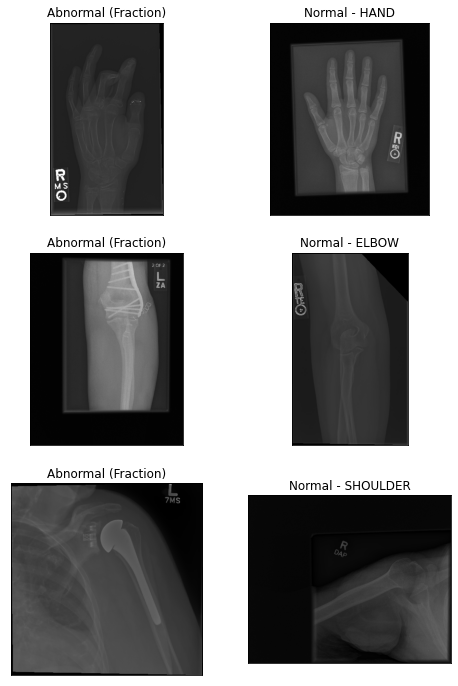

In [54]:
compare_normal_and_abnormal(['HAND', 'ELBOW', 'SHOULDER'])

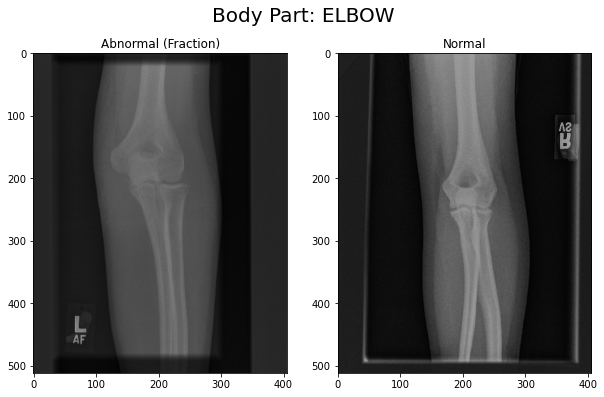

In [20]:
compare_normal_and_abnormal('ELBOW')

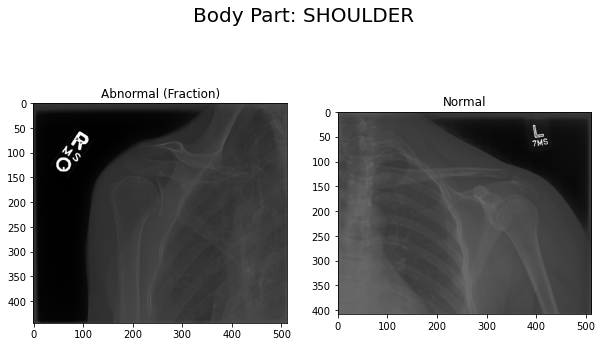

In [22]:
compare_normal_and_abnormal('SHOULDER')

# Focus on Shoulder, Hand and Elbow

In [8]:
class BodyPart(Enum):
    ELBOW = 0
    HAND = 1
    SHOULDER = 2 
    FINGER = 3
    FOREARM = 4
    HUMERUS = 5
    WRIST = 6

    def __eq__(self, other: str):
        return self.value == other

In [9]:
assert 'HAND' == BodyPart.HAND.name

In [10]:
focused_body_parts = [BodyPart.ELBOW.name, BodyPart.SHOULDER.name, BodyPart.HAND.name]

X_train_focused = X_train[X_train['BodyPart'].isin(focused_body_parts)].reset_index(drop=True)
X_val_focused = X_val[X_val['BodyPart'].isin(focused_body_parts)].reset_index(drop=True)

In [11]:
X_train_focused['BodyPartLabel'] = X_train_focused['BodyPart'].apply(lambda x: BodyPart[x].value)
X_val_focused['BodyPartLabel'] = X_val_focused['BodyPart'].apply(lambda x: BodyPart[x].value)

In [11]:
X_train_focused.head()

,filePath,Label,BodyPart,StudyType,BodyPartLabel
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1,2
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1,2
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1,2
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1,2
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1,2


In [12]:
X_train_focused.set_index(["filePath", "BodyPart"]).count(level="BodyPart")
X_train_focused.set_index(["filePath", "Label"]).count(level="Label")

,BodyPart,StudyType,BodyPartLabel
Label,,,
0,11195,11195,11195
1,7658,7658,7658


In [15]:
print(X_train.shape)
print(X_train_focused.shape)

(36808, 4)
(18853, 5)


In [16]:
print(X_val.shape)
print(X_val_focused.shape)

(3197, 4)
(1488, 5)


# Distribution

In [32]:
np.unique(X_train['BodyPart'], return_counts=True)

(array(['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER',
        'WRIST'], dtype=object),
 array([4931, 5106, 1825, 5543, 1272, 8379, 9752]))

Train data:


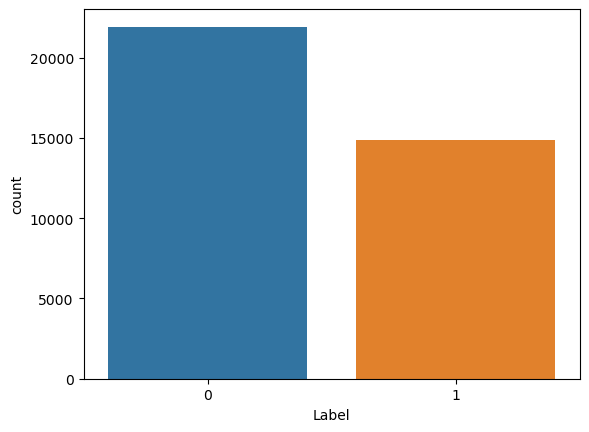

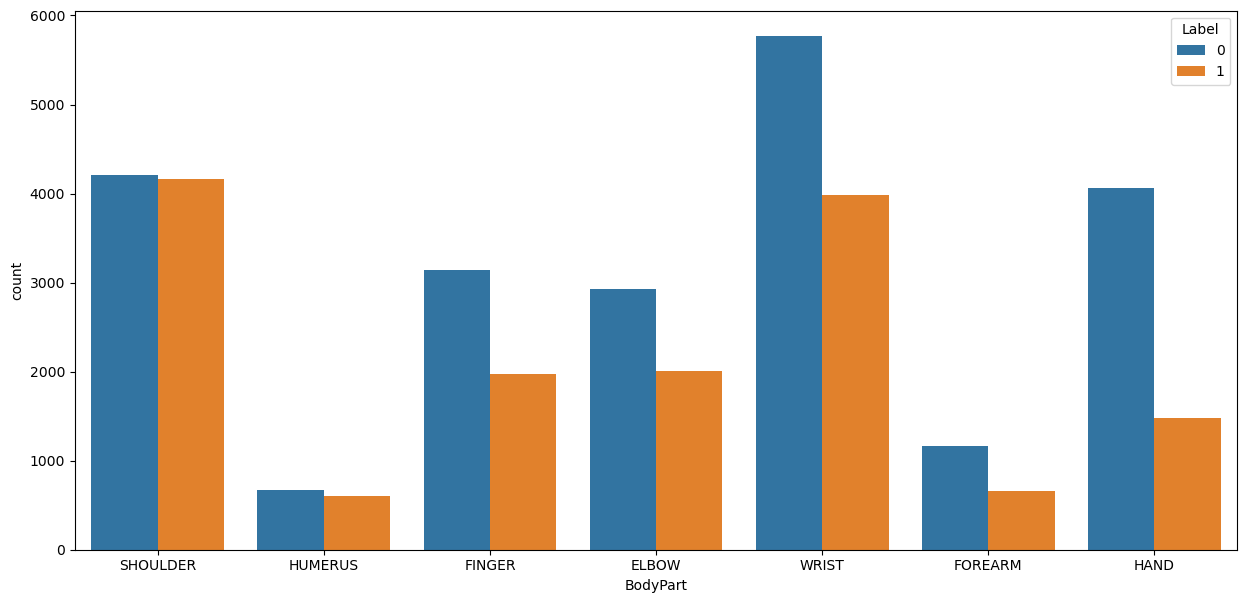

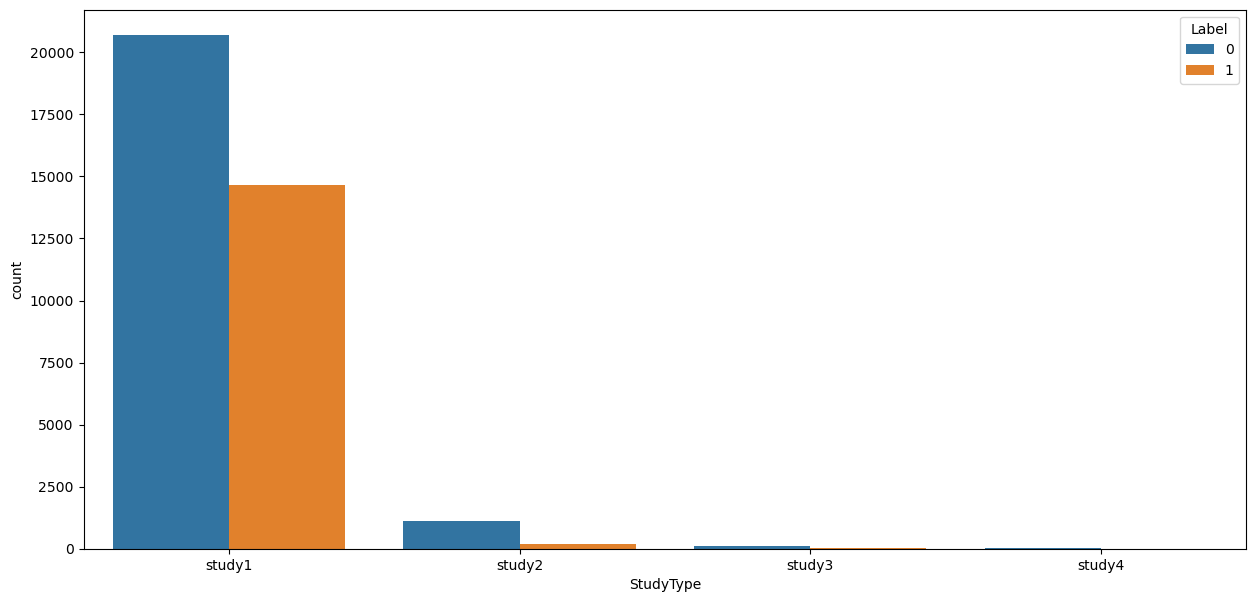

In [33]:
# Train
print('Train data:')
sns.countplot(data=X_train, x='Label')
plt.figure(figsize=(15,7))
sns.countplot(data=X_train,x='BodyPart',hue='Label')
plt.figure(figsize=(15,7))
_ = sns.countplot(data=X_train,x='StudyType',hue='Label')

Validation Data:


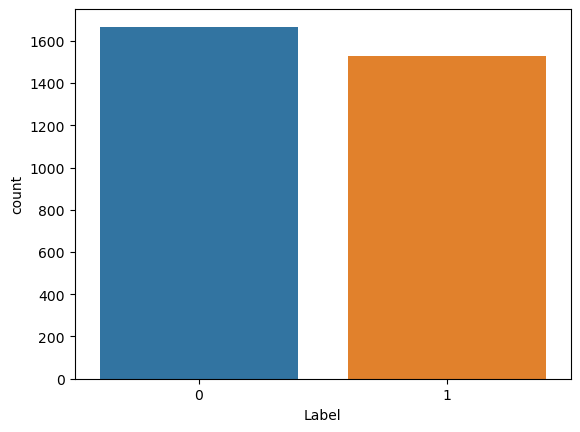

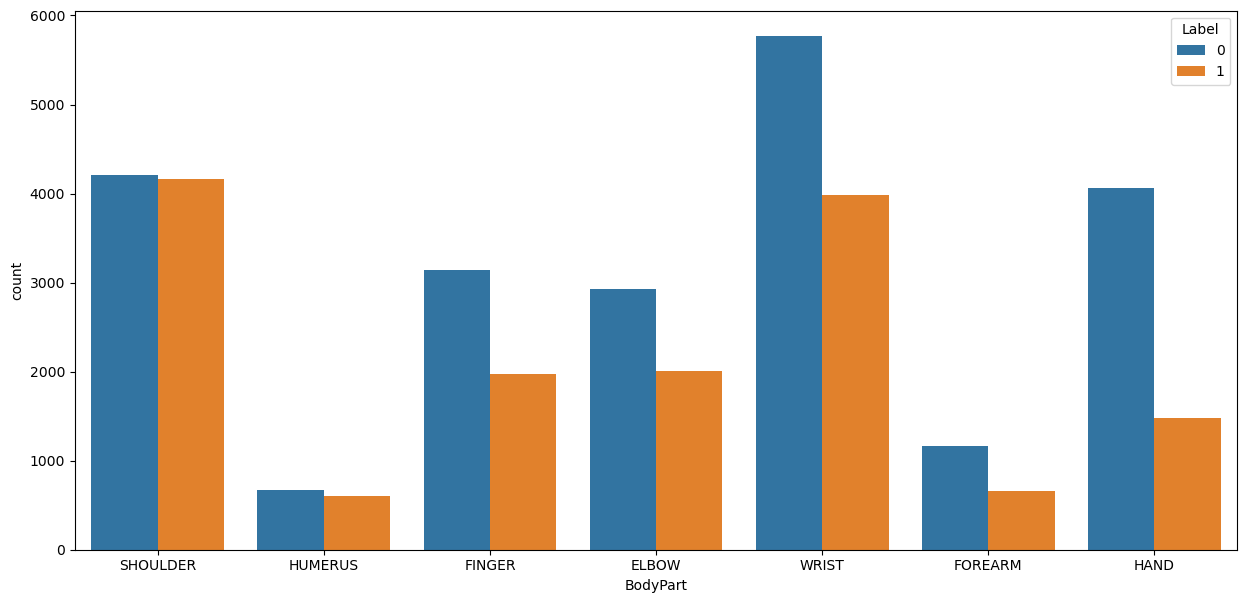

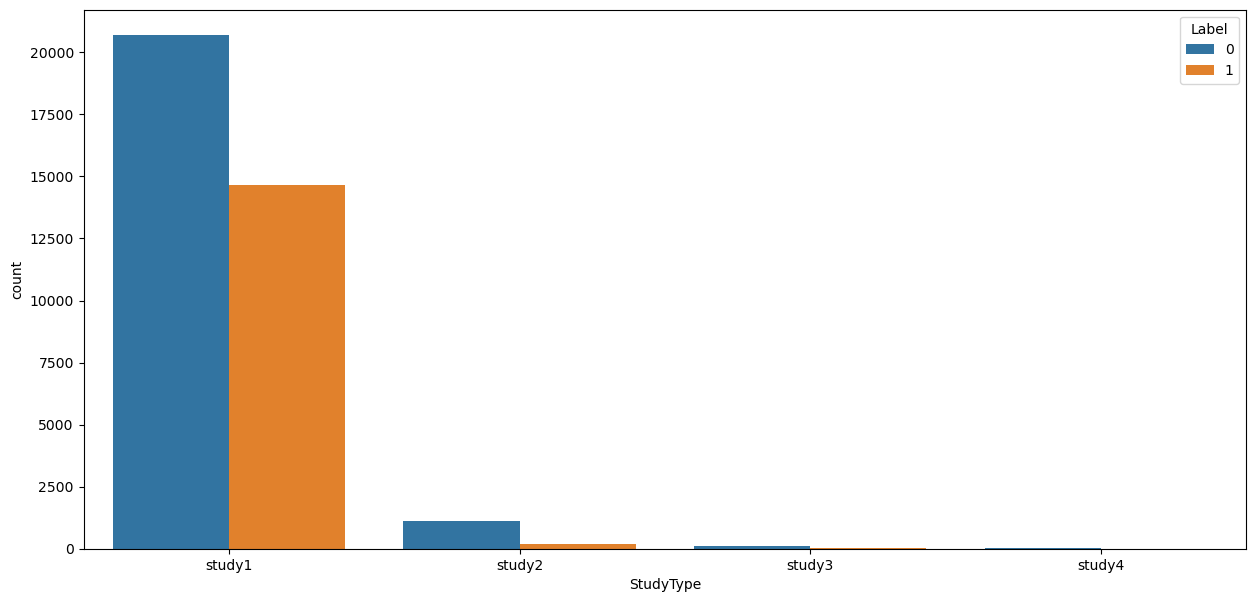

In [34]:
# Validation
print('Validation Data:')
sns.countplot(data=X_val, x='Label')
plt.figure(figsize=(15,7))
sns.countplot(data=X_train,x='BodyPart',hue='Label')
plt.figure(figsize=(15,7))
_ = sns.countplot(data=X_train,x='StudyType',hue='Label')

# Dataset

In [12]:
# Augmentation
height, width = 224, 224
simclr_transform_train = transforms.Compose([
    transforms.RandomResizedCrop((height, width)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])

simclr_transform_val = transforms.Compose([
    transforms.CenterCrop((height, width)),
    transforms.Resize((height, width)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])


default_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])

In [12]:
class SimCLRAugmentedDataset(Dataset):
    def __init__(self, dataset, transform, return_original=False):
        self.dataset = dataset
        self.transform = transform
        self.return_original = return_original
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        # I can remove the label
        img_name=self.dataset.iloc[idx,0]
        img = Image.open(f'{proj_path}/{img_name}')

        img1 = self.transform(img)
        img2 = self.transform(img)
        
        if self.return_original: # for manual inspection
            img = self.transform(img)
            return img, img1, img2
        
        return img1, img2

In [ ]:
class DefaultDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        img_name=self.dataset['filePath'][idx]
        img = Image.open(img_name)

        label=self.dataset['Label'][idx]
        bodyPartLabel = self.dataset['BodyPartLabel'][idx]

        if self.transform:
            img = self.transform(img)

        return img, bodyPartLabel, label

# Pre-trained SimCLR

In [17]:
def nt_xent_loss(features1, features2, temperature):
    """
    Implements the NT-Xent (Normalized Temperature-Scaled Cross Entropy Loss)
    Args:
        features_i, features_j: the features from the last layer of the neural network for two augmented versions of the same image.
        temperature: temperature scaling parameter.
        device: the device on which tensors should be allocated.
    Returns:
        The NT-Xent Loss.
    """
    batch_size = features1.shape[0]

    # normalize the input features
    features1 = F.normalize(features1, dim=1)
    features2 = F.normalize(features2, dim=1)

    # Concatenate the features from both views
    features = torch.cat([features1, features2], dim=0)

    # Compute similarity matrix
    similarity_matrix = torch.mm(features, features.T)
    # Scale the similarity_matrix by temperature
    similarity_matrix /= temperature

    # Create target matrix
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)

    # positives are the similarity scores on the diagonal
    positives = similarity_matrix[mask].view(2 * batch_size, 1)
    # negatives are the similarity scores off the diagonal
    negatives = similarity_matrix[~mask].view(2 * batch_size, batch_size * 2 - 1)

    # Concatenate and calculate cross entropy loss
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=device)
    loss = F.cross_entropy(logits, labels)
    
    return loss


In [18]:
class SimCLR(nn.Module):
    """
        Our SimCLR model is based on the work of Chen et al., as documented in their report. 
        We have taken inspiration from both the deeper version and the first version.
        Chen et al. reported to have superior results with the deeper version.
        However, implementing the deeper version might require additional resources that we may not currently possess.
    """
    def __init__(self, feature_dim=128, to_use_deep_model=False):
        super(SimCLR, self).__init__()
        
        f = nn.Sequential(*list(resnet50(pretrained=True).children())[:-1])
        deep_f = nn.Sequential(*list(resnet152(pretrained=True).children())[:-1])
        
        # Projection head
        g = nn.Sequential(
            nn.Linear(2048, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, feature_dim, bias=True)
        )

        deep_g = nn.Sequential(
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, feature_dim, bias=True)
        )

        self.f = deep_f if to_use_deep_model else f
        self.g = deep_g if to_use_deep_model else g

        # Define Optimizer - combine the parameters of the two parts of the model
        parameters = list(self.f.parameters()) + list(self.g.parameters())
        self.optimizer = AdamW(parameters, lr=0.001, weight_decay=0.01)

    def forward(self, x):
        x = self.f(x)
        representation = torch.flatten(x, start_dim=1)
        out = self.g(representation)
        return out

    def criterion(self, feat1, feat2, temperature):
        return nt_xent_loss(feat1, feat2, temperature)
    
    def train_loop(self, train_dataloader, val_dataloader, 
                   num_epochs=4,
                   temperature=0.08
                   ):
        loss_lists = {'train': [], 'val': []}
        for epoch in tqdm(range(num_epochs)):
            train_loss, val_loss = 0.0, 0.0
            self.train()
            for images1, images2 in train_dataloader:
                images1, images2 = images1.to(device), images2.to(device)
                self.optimizer.zero_grad()
                feature1 = self.forward(images1)
                feature2 = self.forward(images2)

                # Calculate the loss
                loss = self.criterion(feature1, feature2, temperature=0.08)
                train_loss += loss.item()
                # Back-propagation and optimization
                loss.backward()
                self.optimizer.step()
            
            self.eval()
            with torch.no_grad():
                for images1, images2 in val_dataloader:
                    images1, images2 = images1.to(device), images2.to(device)
                    feature1 = self.forward(images1)
                    feature2 = self.forward(images2)
                    loss = self.criterion(feature1, feature2, temperature=0.08)
                    val_loss += loss.item()
            
            
            loss_lists['train'].append( train_loss / len(train_dataloader))
            loss_lists['val'].append( val_loss / len(val_dataloader))
            print()
            print(f'--------------------- Epoch {epoch+1}/{num_epochs}  ---------------------')
            print(f'Train loss: {loss_lists["train"][-1]:.4f}')
            print(f'Val loss: {loss_lists["val"][-1]:.4f}')
            print('====================================================================')
        return loss_lists


In [43]:
# Create the augmented dataset
simclr_train_set = SimCLRAugmentedDataset(X_train_focused, simclr_transform_train)
simclr_train_dataloader = DataLoader(dataset=simclr_train_set, batch_size=64, shuffle=True)

# Validation set
simclr_val_set = SimCLRAugmentedDataset(X_val_focused, simclr_transform_val)
simclr_val_dataloader = DataLoader(dataset=simclr_val_set, batch_size=64, shuffle=True)

### Inspect transformation

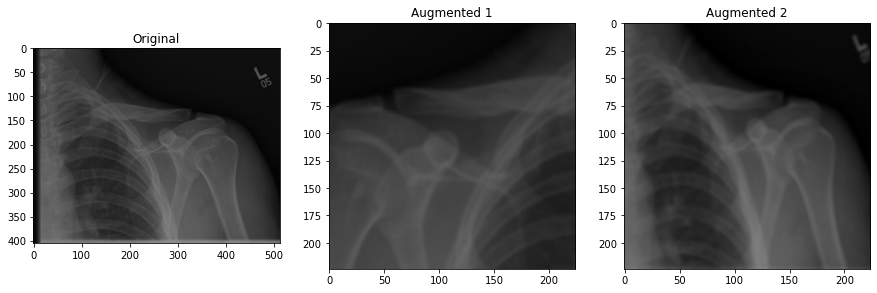

: 

In [83]:
simclr_train_set_inspect = SimCLRAugmentedDataset(X_train_focused, simclr_transform_train, return_original=True)

# Plot the augmented images
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].set_title('Original')
ax[0].imshow(simclr_train_set_inspect[1054][0])
ax[1].set_title('Augmented 1')
ax[1].imshow(simclr_train_set_inspect[1054][1].numpy().transpose(1,2,0))
ax[2].set_title('Augmented 2')
ax[2].imshow(simclr_train_set_inspect[1054][2].numpy().transpose(1,2,0))
plt.show()

# SimCLR training

In this section, we try several options for the training of the SimCLR that will be evaluated later by the teacher (Fine-tuned) model.\
The hyperparametrs that we changed are: learning-rate: 0.03, 0.01, num-epochs: 2,4,6,8,10 an batch-size: 8,32,64.

In [13]:
os.listdir('./pretrained-simclr-models')

['batch_2048',
 'model_4proj.pth',
 '003',
 'model_10.pth',
 'model_8.pth',
 '152',
 'model_4e',
 'model_2.pth']

In [19]:
# Train the SimCLR model
simclr_model = SimCLR(feature_dim=128).to(device)
loss_lists = simclr_model.train_loop(simclr_train_dataloader, simclr_val_dataloader, num_epochs=8)
torch.save(simclr_model.state_dict(), f'./pretrained-simclr-models/003/model_8.pth')

 12%|███▌                        | 1/8 [06:13<43:33, 373.35s/it]


--------------------- Epoch 1/8  ---------------------
Train loss: 0.9720
Val loss: 0.8438


 25%|███████                     | 2/8 [12:28<37:27, 374.54s/it]


--------------------- Epoch 2/8  ---------------------
Train loss: 0.0571
Val loss: 0.7819


 38%|██████████▌                 | 3/8 [18:43<31:12, 374.54s/it]


--------------------- Epoch 3/8  ---------------------
Train loss: 0.0238
Val loss: 0.7249


 50%|██████████████              | 4/8 [24:57<24:57, 374.29s/it]


--------------------- Epoch 4/8  ---------------------
Train loss: 0.0113
Val loss: 0.8644


 62%|█████████████████▌          | 5/8 [31:12<18:43, 374.60s/it]


--------------------- Epoch 5/8  ---------------------
Train loss: 0.0093
Val loss: 0.7282


 75%|█████████████████████       | 6/8 [37:27<12:29, 374.75s/it]


--------------------- Epoch 6/8  ---------------------
Train loss: 0.0105
Val loss: 1.1737


 88%|████████████████████████▌   | 7/8 [43:40<06:14, 374.26s/it]


--------------------- Epoch 7/8  ---------------------
Train loss: 0.0104
Val loss: 0.7021


100%|████████████████████████████| 8/8 [49:53<00:00, 374.19s/it]


--------------------- Epoch 8/8  ---------------------
Train loss: 0.0071
Val loss: 1.3071


# Fine tuning

To substantiate our argument with minimal computational resources, we directed our focus towards fine-tuning on a subset of 10% of the data.

Initially, we considered three versions of the model, all sharing common hyperparameters. \
These versions include the deep version, the first version, and one with a specific objective (please refer to the report for more detailed information). \
We then evaluated their performance and selected the one that showed promising results.\
Then, we fine tuned the selected model.\
\
Due to computational time constraints, we opted for this strategy instead of performing full fine-tuning on all pre-trained models and hyperparameters.\
It is commonly known from related works that the deeper version, with a sufficiently large batch size, yields better results.\
However, our current computational resources are limited, preventing us from pursuing that approach. \
Hence, we need to analyze the performance of these three versions on our machine.\

In [22]:
os.listdir('./pretrained-simclr-models/')

['batch_2048',
 'model_4proj.pth',
 'model_10.pth',
 'model_8.pth',
 'model_4e',
 'model_2.pth']

In [29]:
class TeacherModel(nn.Module):
    def __init__(self, simclr_model, learning_rate=0.001, weight_decay=0.01, num_body_parts=3):
        super().__init__()
        # Use the encoder from the SimCLR model
        self.encoder = simclr_model.f

        self.base_model = nn.Sequential(
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
        )

        self.part_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_body_parts, bias=True)
        )

        self.fraction_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2, bias=True)
        )

        # Freeze the encoder since memory constraints issues
        self.encoder.requires_grad_(False)

        parameters = list(self.part_classifier.parameters())+list(self.fraction_classifier.parameters()) + list(self.base_model.parameters())
        self.optimizer = AdamW(parameters, lr=learning_rate, weight_decay=weight_decay)

        self.cross_entropy = nn.CrossEntropyLoss().to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        # x = self.semi_proj(x)
        x = self.base_model(x)
        x_body_part = self.part_classifier(x)
        x_fraction = self.fraction_classifier(x)
        return x_body_part, x_fraction
    
    # def train_loop(self, train_dataloader, val_dataloader, num_epochs):
    #     loss_lst = {'train': [], 'val': []}
    #     fraction_acc_lst = {'train': [], 'val': []}
    #     body_part_acc_lst = {'train': [], 'val': []}
        
    #     for epoch in tqdm(range(num_epochs)):
    #         train_loss, val_loss = 0.0, 0.0
    #         fraction_train_correct, fraction_val_correct = 0.0, 0.0
    #         body_part_train_correct, body_part_val_correct = 0.0, 0.0

    #         self.train()
    #         for images, body_parts, labels in train_dataloader:
    #             images, body_parts, labels = images.to(device), body_parts.to(device), labels.to(device)
    #             self.optimizer.zero_grad()
    #             out_body_parts, out_fractions = self.forward(images)
                
    #             # Calculate loss
    #             loss_body_parts = self.cross_entropy(out_body_parts, body_parts)
    #             loss_fractions = self.cross_entropy(out_fractions, labels)
    #             loss = loss_body_parts + loss_fractions
    #             train_loss += loss.item()

    #             _, predicted_body_part = torch.max(out_body_parts.data, 1)
    #             _, predicted_fraction = torch.max(out_fractions.data, 1)

    #             # Calculate accuracy (for batch)
    #             body_part_train_correct += (predicted_body_part == body_parts).sum().item()
    #             correct_fraction_predictions = (predicted_fraction == labels)
    #             fraction_train_correct += correct_fraction_predictions.sum().item()

    #             loss.backward()
    #             self.optimizer.step()
                            
    #         self.eval()
    #         with torch.no_grad():
    #             for images, body_parts, labels in val_dataloader:
    #                 images, body_parts, labels = images.to(device), body_parts.to(device), labels.to(device)
    #                 out_body_parts, out_fractions = self.forward(images)
    #                 # Calculate loss
    #                 loss_body_parts = self.cross_entropy(out_body_parts, body_parts)
    #                 loss_fractions = self.cross_entropy(out_fractions, labels)
    #                 loss = loss_body_parts + loss_fractions
    #                 val_loss += loss.item()

    #                 _, predicted_body_part = torch.max(out_body_parts.data, 1)
    #                 _, predicted_fraction = torch.max(out_fractions.data, 1)
                    
    #                 # Calculate accuracy (for batch)
    #                 body_part_val_correct += (predicted_body_part == body_parts).sum().item()

    #                 correct_fraction_predictions = (predicted_fraction == labels)
    #                 fraction_val_correct += correct_fraction_predictions.sum().item()
            
    #         loss_lst['train'].append(train_loss / len(train_dataloader))
    #         loss_lst['val'].append(val_loss / len(val_dataloader))

    #         fraction_acc_lst['train'].append(fraction_train_correct / len(train_dataloader.dataset))
    #         fraction_acc_lst['val'].append(fraction_val_correct / len(val_dataloader.dataset))

    #         body_part_acc_lst['train'].append(body_part_train_correct / len(train_dataloader.dataset))
    #         body_part_acc_lst['val'].append(body_part_val_correct / len(val_dataloader.dataset))
            
    #         print()
    #         print(f'--------------------- Epoch {epoch+1}/{num_epochs}  ---------------------')
    #         print("Train: ")
    #         print(f'Train loss: {loss_lst["train"][-1]:.4f}')
    #         print(f'Train fraction accuracy: {fraction_acc_lst["train"][-1]:.4f}')
    #         print(f'Train body part accuracy: {body_part_acc_lst["train"][-1]:.4f}')
    #         print()
    #         print("Val: ")
    #         print(f'Val loss: {loss_lst["val"][-1]:.4f}')
    #         print(f'Val fraction accuracy: {fraction_acc_lst["val"][-1]:.4f}')
    #         print(f'Val body part accuracy: {body_part_acc_lst["val"][-1]:.4f}')
    #         print('====================================================================')
    #     return loss_lst, fraction_acc_lst, body_part_acc_lst      


In [ ]:
class DeepTeacherModel(nn.Module):
    def __init__(self, simclr_model, learning_rate=0.001, weight_decay=0.01, num_body_parts=3):
        super().__init__()
        # Use the encoder from the SimCLR model
        self.encoder = simclr_model.f
        self.semi_proj = simclr_model.g[:4]
        self.base_model = nn.Sequential(
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
        )

        self.part_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_body_parts, bias=True)
        )

        self.fraction_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2, bias=True)
        )

        # Freeze the encoder since memory constraints issues
        self.encoder.requires_grad_(False)

        parameters = list(self.part_classifier.parameters())+list(self.fraction_classifier.parameters()) + list(self.base_model.parameters()) + list(self.semi_proj.parameters())
        self.optimizer = AdamW(parameters, lr=learning_rate, weight_decay=weight_decay)

        self.cross_entropy = nn.CrossEntropyLoss().to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.semi_proj(x)
        x = self.base_model(x)
        x_body_part = self.part_classifier(x)
        x_fraction = self.fraction_classifier(x)
        return x_body_part, x_fraction 


In [ ]:
class OneObjectiveTeacherModel(nn.Module):
    def __init__(self, simclr_model, learning_rate=0.001, weight_decay=0.01, num_body_parts=3):
        super().__init__()
        # Use the encoder from the SimCLR model
        self.encoder = simclr_model.f

        self.base_model = nn.Sequential(
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
        )

        self.fraction_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2, bias=True)
        )

        # Freeze the encoder since memory constraints issues
        self.encoder.requires_grad_(False)

        parameters = list(self.fraction_classifier.parameters()) + list(self.base_model.parameters())
        self.optimizer = AdamW(parameters, lr=learning_rate, weight_decay=weight_decay)

        self.cross_entropy = nn.CrossEntropyLoss().to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.base_model(x)
        x_fraction = self.fraction_classifier(x)
        return x_fraction


In [ ]:
def multitasking_teacher_train_loop(model, train_dataloader, val_dataloader, num_epochs):
    loss_lst = {'train': [], 'val': []}
    fraction_acc_lst = {'train': [], 'val': []}
    body_part_acc_lst = {'train': [], 'val': []}

    for epoch in tqdm(range(num_epochs)):
        train_loss, val_loss = 0.0, 0.0
        fraction_train_correct, fraction_val_correct = 0.0, 0.0
        body_part_train_correct, body_part_val_correct = 0.0, 0.0

        model.train()
        for images, body_parts, labels in train_dataloader:
            images, body_parts, labels = images.to(device), body_parts.to(device), labels.to(device)
            model.optimizer.zero_grad()
            out_body_parts, out_fractions = model.forward(images)
            
            # Calculate loss
            loss_body_parts = model.cross_entropy(out_body_parts, body_parts)
            loss_fractions = model.cross_entropy(out_fractions, labels)
            loss = loss_body_parts + loss_fractions
            train_loss += loss.item()

            _, predicted_body_part = torch.max(out_body_parts.data, 1)
            _, predicted_fraction = torch.max(out_fractions.data, 1)

            # Calculate accuracy (for batch)
            body_part_train_correct += (predicted_body_part == body_parts).sum().item()
            correct_fraction_predictions = (predicted_fraction == labels)
            fraction_train_correct += correct_fraction_predictions.sum().item()

            loss.backward()
            model.optimizer.step()
                        
        model.eval()
        with torch.no_grad():
            for images, body_parts, labels in val_dataloader:
                images, body_parts, labels = images.to(device), body_parts.to(device), labels.to(device)
                out_body_parts, out_fractions = model.forward(images)
                # Calculate loss
                loss_body_parts = model.cross_entropy(out_body_parts, body_parts)
                loss_fractions = model.cross_entropy(out_fractions, labels)
                loss = loss_body_parts + loss_fractions
                val_loss += loss.item()

                _, predicted_body_part = torch.max(out_body_parts.data, 1)
                _, predicted_fraction = torch.max(out_fractions.data, 1)
                
                # Calculate accuracy (for batch)
                body_part_val_correct += (predicted_body_part == body_parts).sum().item()

                correct_fraction_predictions = (predicted_fraction == labels)
                fraction_val_correct += correct_fraction_predictions.sum().item()
        
        loss_lst['train'].append(train_loss / len(train_dataloader))
        loss_lst['val'].append(val_loss / len(val_dataloader))

        fraction_acc_lst['train'].append(fraction_train_correct / len(train_dataloader.dataset))
        fraction_acc_lst['val'].append(fraction_val_correct / len(val_dataloader.dataset))

        body_part_acc_lst['train'].append(body_part_train_correct / len(train_dataloader.dataset))
        body_part_acc_lst['val'].append(body_part_val_correct / len(val_dataloader.dataset))
        
        print()
        print(f'--------------------- Epoch {epoch+1}/{num_epochs}  ---------------------')
        print("Train: ")
        print(f'Train loss: {loss_lst["train"][-1]:.4f}')
        print(f'Train fraction accuracy: {fraction_acc_lst["train"][-1]:.4f}')
        print(f'Train body part accuracy: {body_part_acc_lst["train"][-1]:.4f}')
        print()
        print("Val: ")
        print(f'Val loss: {loss_lst["val"][-1]:.4f}')
        print(f'Val fraction accuracy: {fraction_acc_lst["val"][-1]:.4f}')
        print(f'Val body part accuracy: {body_part_acc_lst["val"][-1]:.4f}')
        print('====================================================================')
    return loss_lst, fraction_acc_lst, body_part_acc_lst     

In [ ]:
def one_objective_teacher_train_loop(model, train_dataloader, val_dataloader, num_epochs):
    loss_lst = {'train': [], 'val': []}
    fraction_acc_lst = {'train': [], 'val': []}
    body_part_acc_lst = {'train': [], 'val': []}

    for epoch in tqdm(range(num_epochs)):
        train_loss, val_loss = 0.0, 0.0
        fraction_train_correct, fraction_val_correct = 0.0, 0.0

        model.train()
        for images, _, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            model.optimizer.zero_grad()
            out_fractions = model.forward(images)
            
            # Calculate loss
            loss = model.cross_entropy(out_fractions, labels)
            train_loss += loss.item()

            _, predicted_fraction = torch.max(out_fractions.data, 1)

            # Calculate accuracy (for batch)
            correct_fraction_predictions = (predicted_fraction == labels)
            fraction_train_correct += correct_fraction_predictions.sum().item()

            loss.backward()
            model.optimizer.step()
                        
        model.eval()
        with torch.no_grad():
            for images, _, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                out_fractions = model.forward(images)
                # Calculate loss
                loss = model.cross_entropy(out_fractions, labels)
                val_loss += loss.item()

                _, predicted_fraction = torch.max(out_fractions.data, 1)
                
                # Calculate accuracy (for batch)
                correct_fraction_predictions = (predicted_fraction == labels)
                fraction_val_correct += correct_fraction_predictions.sum().item()
        
        loss_lst['train'].append(train_loss / len(train_dataloader))
        loss_lst['val'].append(val_loss / len(val_dataloader))

        fraction_acc_lst['train'].append(fraction_train_correct / len(train_dataloader.dataset))
        fraction_acc_lst['val'].append(fraction_val_correct / len(val_dataloader.dataset))
        
        print()
        print(f'--------------------- Epoch {epoch+1}/{num_epochs}  ---------------------')
        print("Train: ")
        print(f'Train loss: {loss_lst["train"][-1]:.4f}')
        print(f'Train fraction accuracy: {fraction_acc_lst["train"][-1]:.4f}')
        print()
        print("Val: ")
        print(f'Val loss: {loss_lst["val"][-1]:.4f}')
        print(f'Val fraction accuracy: {fraction_acc_lst["val"][-1]:.4f}')
        print('====================================================================')
    return loss_lst, fraction_acc_lst, body_part_acc_lst     

In [22]:
def prepare_train_dataloader(x_percent, batch_size=64) -> DataLoader:
        
    def get_x_percent_of_data(x):
        # Get x% of each body part in the training data
        selected_data = []
        for body_part in focused_body_parts:
            df_body_part = X_train_focused[X_train_focused['BodyPart'] == body_part]
            num_to_select = int(df_body_part.shape[0] * x)
            df_body_part = df_body_part.sample(n=num_to_select)
            selected_data.append(df_body_part)
        
        return pd.concat(selected_data).reset_index(drop=True)
    
    dataset = get_x_percent_of_data(x_percent) if 0 < x_percent < 1 else X_train_focused
    curr_data = DefaultDataset(dataset, default_transform)
    train_dataloader = DataLoader(dataset=curr_data, batch_size=batch_size, shuffle=True)
    return train_dataloader

### First comparison "raw" models

In [ ]:
batch_size = 8
train_dataloader = prepare_train_dataloader(0.1, batch_size)

val_data = DefaultDataset(X_val_focused, transform=default_transform)
val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

In [ ]:
os.mkdir('./fined-tuned-models/start')

In [ ]:
pretrained_model = SimCLR().to(device)
pretrained_model.load_state_dict(torch.load('./pretrained-simclr-models/model_4e'))

deep_pretrained_model = SimCLR(to_use_deep_model=True).to(device)
deep_pretrained_model.load_state_dict(torch.load('./pretrained-simclr-models/model_4proj.pth'))

lr = 0.003
wd = 0.001

multitasking_models = [
    TeacherModel(pretrained_model, learning_rate=lr, weight_decay=wd).to(device),
    DeepTeacherModel(deep_pretrained_model, learning_rate=lr, weight_decay=wd).to(device),
]

one_objective_model =  OneObjectiveTeacherModel(pretrained_model, learning_rate=lr, weight_decay=wd).to(device),

res = []

for i, model in enumerate(multitasking_models):
    print()
    print()
    print(f"#########   ######  #########   ###########   ########  ########  #######  ########")
    print()

    losses, fraction_acc, body_part_acc = model.train_loop(train_dataloader, val_dataloader, num_epochs=4)
    res.append(losses, fraction_acc, body_part_acc)
    torch.save(model.state_dict(), f'./fined-tuned-models/start/{i}-multi.pth')


losses, fraction_acc = model.train_loop(train_dataloader, val_dataloader, num_epochs=4)
res.append(losses, fraction_acc)
torch.save(model.state_dict(), f'./fined-tuned-models/start/2-one-objective.pth')

#### Based on the comparison above, choose the Teacher model and fine-tune it.

In [ ]:
os.listdir('./fined-tuned-models')

['v3',
 "model_['1', '10', '100']",
 'v4',
 'model_100',
 'v2',
 'model_1',
 'v5',
 'model_10']

In [ ]:
# fine tune the model on 10% since it faster and we assume that the same will optimize the 100%. And considered teh Azure hours constraints

results = {}

for batch_size in [32, 64]:
    for learning_rate in [0.001, 0.003, 0.01]:
        for weight_decay in [0.001, 0.01]:
            print()
            print()
            print(f"#########   ######  #########   m_{batch_size}_{learning_rate}_{weight_decay} ###########   ########  ########  #######  ########")
            print()
            train_dataloader = prepare_train_dataloader(0.1, batch_size)
            val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
            
            teacher_model = TeacherModel(pretrained_model, learning_rate=learning_rate, weight_decay=weight_decay).to(device)
            losses, fraction_acc, body_part_acc = teacher_model.train_loop(train_dataloader, val_dataloader, num_epochs=20)
            results[(batch_size, learning_rate, weight_decay)] = (losses, fraction_acc, body_part_acc)
            torch.save(teacher_model.state_dict(), f'./fined-tuned-models/v5/20m_{batch_size}_{learning_rate}_{weight_decay}.pth')



#########   ######  #########   m_64_0.001_0.001 ###########   ########  ########  #######  ########



  5%|███▎                                                             | 1/20 [00:42<13:32, 42.74s/it]


--------------------- Epoch 1/20  ---------------------
Train: 
Train loss: 1.5690
Train fraction accuracy: 0.5393
Train body part accuracy: 0.6104

Val: 
Val loss: 1.5015
Val fraction accuracy: 0.5302
Val body part accuracy: 0.6478


 10%|██████▌                                                          | 2/20 [01:16<11:15, 37.54s/it]


--------------------- Epoch 2/20  ---------------------
Train: 
Train loss: 1.4035
Train fraction accuracy: 0.5807
Train body part accuracy: 0.6879

Val: 
Val loss: 1.4886
Val fraction accuracy: 0.5276
Val body part accuracy: 0.6431


 15%|█████████▊                                                       | 3/20 [01:49<10:03, 35.50s/it]


--------------------- Epoch 3/20  ---------------------
Train: 
Train loss: 1.3144
Train fraction accuracy: 0.5913
Train body part accuracy: 0.7240

Val: 
Val loss: 1.4155
Val fraction accuracy: 0.5363
Val body part accuracy: 0.6821


 20%|█████████████                                                    | 4/20 [02:24<09:22, 35.19s/it]


--------------------- Epoch 4/20  ---------------------
Train: 
Train loss: 1.2790
Train fraction accuracy: 0.5908
Train body part accuracy: 0.7484

Val: 
Val loss: 1.3695
Val fraction accuracy: 0.5336
Val body part accuracy: 0.7083


 25%|████████████████▎                                                | 5/20 [02:57<08:34, 34.32s/it]


--------------------- Epoch 5/20  ---------------------
Train: 
Train loss: 1.2454
Train fraction accuracy: 0.5961
Train body part accuracy: 0.7670

Val: 
Val loss: 1.6046
Val fraction accuracy: 0.5255
Val body part accuracy: 0.6499


 30%|███████████████████▌                                             | 6/20 [03:30<07:54, 33.90s/it]


--------------------- Epoch 6/20  ---------------------
Train: 
Train loss: 1.2137
Train fraction accuracy: 0.6035
Train body part accuracy: 0.7755

Val: 
Val loss: 1.3821
Val fraction accuracy: 0.5302
Val body part accuracy: 0.7231


 35%|██████████████████████▊                                          | 7/20 [04:03<07:17, 33.68s/it]


--------------------- Epoch 7/20  ---------------------
Train: 
Train loss: 1.2154
Train fraction accuracy: 0.6115
Train body part accuracy: 0.7765

Val: 
Val loss: 1.3800
Val fraction accuracy: 0.5235
Val body part accuracy: 0.7406


 40%|██████████████████████████                                       | 8/20 [04:36<06:42, 33.52s/it]


--------------------- Epoch 8/20  ---------------------
Train: 
Train loss: 1.1921
Train fraction accuracy: 0.6035
Train body part accuracy: 0.7903

Val: 
Val loss: 1.3552
Val fraction accuracy: 0.5323
Val body part accuracy: 0.7399


 45%|█████████████████████████████▎                                   | 9/20 [05:08<06:04, 33.13s/it]


--------------------- Epoch 9/20  ---------------------
Train: 
Train loss: 1.1436
Train fraction accuracy: 0.6136
Train body part accuracy: 0.8025

Val: 
Val loss: 1.4076
Val fraction accuracy: 0.5450
Val body part accuracy: 0.7251


 50%|████████████████████████████████                                | 10/20 [05:41<05:29, 33.00s/it]


--------------------- Epoch 10/20  ---------------------
Train: 
Train loss: 1.1832
Train fraction accuracy: 0.6024
Train body part accuracy: 0.7872

Val: 
Val loss: 1.3635
Val fraction accuracy: 0.5222
Val body part accuracy: 0.7366


 55%|███████████████████████████████████▏                            | 11/20 [06:14<04:56, 32.97s/it]


--------------------- Epoch 11/20  ---------------------
Train: 
Train loss: 1.1435
Train fraction accuracy: 0.6131
Train body part accuracy: 0.8179

Val: 
Val loss: 1.4464
Val fraction accuracy: 0.5222
Val body part accuracy: 0.7083


 60%|██████████████████████████████████████▍                         | 12/20 [06:48<04:25, 33.20s/it]


--------------------- Epoch 12/20  ---------------------
Train: 
Train loss: 1.1119
Train fraction accuracy: 0.6285
Train body part accuracy: 0.8041

Val: 
Val loss: 1.4132
Val fraction accuracy: 0.5235
Val body part accuracy: 0.7090


 65%|█████████████████████████████████████████▌                      | 13/20 [07:20<03:50, 33.00s/it]


--------------------- Epoch 13/20  ---------------------
Train: 
Train loss: 1.1276
Train fraction accuracy: 0.6237
Train body part accuracy: 0.8121

Val: 
Val loss: 1.3033
Val fraction accuracy: 0.5202
Val body part accuracy: 0.7695


 70%|████████████████████████████████████████████▊                   | 14/20 [07:53<03:16, 32.82s/it]


--------------------- Epoch 14/20  ---------------------
Train: 
Train loss: 1.1107
Train fraction accuracy: 0.6423
Train body part accuracy: 0.8089

Val: 
Val loss: 1.3553
Val fraction accuracy: 0.5255
Val body part accuracy: 0.7399


 75%|████████████████████████████████████████████████                | 15/20 [08:27<02:45, 33.20s/it]


--------------------- Epoch 15/20  ---------------------
Train: 
Train loss: 1.0742
Train fraction accuracy: 0.6316
Train body part accuracy: 0.8248

Val: 
Val loss: 1.2803
Val fraction accuracy: 0.5262
Val body part accuracy: 0.7870


 80%|███████████████████████████████████████████████████▏            | 16/20 [08:59<02:12, 33.00s/it]


--------------------- Epoch 16/20  ---------------------
Train: 
Train loss: 1.0455
Train fraction accuracy: 0.6497
Train body part accuracy: 0.8349

Val: 
Val loss: 1.3554
Val fraction accuracy: 0.5202
Val body part accuracy: 0.7325


 85%|██████████████████████████████████████████████████████▍         | 17/20 [09:32<01:38, 32.93s/it]


--------------------- Epoch 17/20  ---------------------
Train: 
Train loss: 1.0423
Train fraction accuracy: 0.6598
Train body part accuracy: 0.8424

Val: 
Val loss: 1.3025
Val fraction accuracy: 0.5202
Val body part accuracy: 0.7782


 90%|█████████████████████████████████████████████████████████▌      | 18/20 [10:05<01:05, 32.91s/it]


--------------------- Epoch 18/20  ---------------------
Train: 
Train loss: 1.0639
Train fraction accuracy: 0.6438
Train body part accuracy: 0.8190

Val: 
Val loss: 1.3904
Val fraction accuracy: 0.5255
Val body part accuracy: 0.7379


 95%|████████████████████████████████████████████████████████████▊   | 19/20 [10:39<00:33, 33.10s/it]


--------------------- Epoch 19/20  ---------------------
Train: 
Train loss: 1.0552
Train fraction accuracy: 0.6385
Train body part accuracy: 0.8254

Val: 
Val loss: 1.3133
Val fraction accuracy: 0.5390
Val body part accuracy: 0.7614


100%|████████████████████████████████████████████████████████████████| 20/20 [11:11<00:00, 33.59s/it]



--------------------- Epoch 20/20  ---------------------
Train: 
Train loss: 1.0031
Train fraction accuracy: 0.6486
Train body part accuracy: 0.8562

Val: 
Val loss: 1.3452
Val fraction accuracy: 0.5390
Val body part accuracy: 0.7648


#########   ######  #########   m_64_0.001_0.01 ###########   ########  ########  #######  ########



  5%|███▎                                                             | 1/20 [00:44<14:05, 44.51s/it]


--------------------- Epoch 1/20  ---------------------
Train: 
Train loss: 1.5332
Train fraction accuracy: 0.5382
Train body part accuracy: 0.6369

Val: 
Val loss: 1.5057
Val fraction accuracy: 0.5356
Val body part accuracy: 0.6599


 10%|██████▌                                                          | 2/20 [01:17<11:24, 38.02s/it]


--------------------- Epoch 2/20  ---------------------
Train: 
Train loss: 1.4107
Train fraction accuracy: 0.5547
Train body part accuracy: 0.7022

Val: 
Val loss: 1.4153
Val fraction accuracy: 0.5269
Val body part accuracy: 0.7103


 15%|█████████▊                                                       | 3/20 [01:50<10:06, 35.70s/it]


--------------------- Epoch 3/20  ---------------------
Train: 
Train loss: 1.3376
Train fraction accuracy: 0.5695
Train body part accuracy: 0.7298

Val: 
Val loss: 1.4487
Val fraction accuracy: 0.5249
Val body part accuracy: 0.7036


 20%|█████████████                                                    | 4/20 [02:23<09:14, 34.63s/it]


--------------------- Epoch 4/20  ---------------------
Train: 
Train loss: 1.3047
Train fraction accuracy: 0.5780
Train body part accuracy: 0.7500

Val: 
Val loss: 1.3820
Val fraction accuracy: 0.5148
Val body part accuracy: 0.7137


 25%|████████████████▎                                                | 5/20 [02:57<08:31, 34.13s/it]


--------------------- Epoch 5/20  ---------------------
Train: 
Train loss: 1.2954
Train fraction accuracy: 0.5690
Train body part accuracy: 0.7590

Val: 
Val loss: 1.3821
Val fraction accuracy: 0.5195
Val body part accuracy: 0.7198


 30%|███████████████████▌                                             | 6/20 [03:31<07:58, 34.18s/it]


--------------------- Epoch 6/20  ---------------------
Train: 
Train loss: 1.2389
Train fraction accuracy: 0.5929
Train body part accuracy: 0.7649

Val: 
Val loss: 1.4548
Val fraction accuracy: 0.5491
Val body part accuracy: 0.6909


 35%|██████████████████████▊                                          | 7/20 [04:04<07:18, 33.72s/it]


--------------------- Epoch 7/20  ---------------------
Train: 
Train loss: 1.2300
Train fraction accuracy: 0.5971
Train body part accuracy: 0.7654

Val: 
Val loss: 1.2684
Val fraction accuracy: 0.5276
Val body part accuracy: 0.7614


 40%|██████████████████████████                                       | 8/20 [04:37<06:41, 33.46s/it]


--------------------- Epoch 8/20  ---------------------
Train: 
Train loss: 1.1994
Train fraction accuracy: 0.5918
Train body part accuracy: 0.7861

Val: 
Val loss: 1.4195
Val fraction accuracy: 0.5309
Val body part accuracy: 0.6989


 45%|█████████████████████████████▎                                   | 9/20 [05:10<06:09, 33.59s/it]


--------------------- Epoch 9/20  ---------------------
Train: 
Train loss: 1.1902
Train fraction accuracy: 0.6168
Train body part accuracy: 0.7797

Val: 
Val loss: 1.3287
Val fraction accuracy: 0.5228
Val body part accuracy: 0.7359


 50%|████████████████████████████████                                | 10/20 [05:44<05:34, 33.48s/it]


--------------------- Epoch 10/20  ---------------------
Train: 
Train loss: 1.1784
Train fraction accuracy: 0.6131
Train body part accuracy: 0.7930

Val: 
Val loss: 1.5316
Val fraction accuracy: 0.5383
Val body part accuracy: 0.7009


 55%|███████████████████████████████████▏                            | 11/20 [06:17<05:01, 33.50s/it]


--------------------- Epoch 11/20  ---------------------
Train: 
Train loss: 1.1183
Train fraction accuracy: 0.6210
Train body part accuracy: 0.8073

Val: 
Val loss: 1.2739
Val fraction accuracy: 0.5329
Val body part accuracy: 0.7675


 60%|██████████████████████████████████████▍                         | 12/20 [06:52<04:31, 33.96s/it]


--------------------- Epoch 12/20  ---------------------
Train: 
Train loss: 1.1192
Train fraction accuracy: 0.5998
Train body part accuracy: 0.8153

Val: 
Val loss: 1.5661
Val fraction accuracy: 0.5430
Val body part accuracy: 0.6741


 65%|█████████████████████████████████████████▌                      | 13/20 [07:26<03:57, 33.96s/it]


--------------------- Epoch 13/20  ---------------------
Train: 
Train loss: 1.1524
Train fraction accuracy: 0.6173
Train body part accuracy: 0.7999

Val: 
Val loss: 1.2937
Val fraction accuracy: 0.5356
Val body part accuracy: 0.7534


 70%|████████████████████████████████████████████▊                   | 14/20 [08:01<03:25, 34.21s/it]


--------------------- Epoch 14/20  ---------------------
Train: 
Train loss: 1.0997
Train fraction accuracy: 0.6470
Train body part accuracy: 0.8238

Val: 
Val loss: 1.2700
Val fraction accuracy: 0.5430
Val body part accuracy: 0.7641


 75%|████████████████████████████████████████████████                | 15/20 [08:35<02:51, 34.26s/it]


--------------------- Epoch 15/20  ---------------------
Train: 
Train loss: 1.1153
Train fraction accuracy: 0.6300
Train body part accuracy: 0.8110

Val: 
Val loss: 1.5316
Val fraction accuracy: 0.5430
Val body part accuracy: 0.6673


 80%|███████████████████████████████████████████████████▏            | 16/20 [09:10<02:16, 34.24s/it]


--------------------- Epoch 16/20  ---------------------
Train: 
Train loss: 1.0733
Train fraction accuracy: 0.6162
Train body part accuracy: 0.8344

Val: 
Val loss: 1.2659
Val fraction accuracy: 0.5121
Val body part accuracy: 0.7796


 85%|██████████████████████████████████████████████████████▍         | 17/20 [09:43<01:41, 33.95s/it]


--------------------- Epoch 17/20  ---------------------
Train: 
Train loss: 1.0714
Train fraction accuracy: 0.6375
Train body part accuracy: 0.8158

Val: 
Val loss: 1.2309
Val fraction accuracy: 0.5551
Val body part accuracy: 0.7883


 90%|█████████████████████████████████████████████████████████▌      | 18/20 [10:18<01:08, 34.28s/it]


--------------------- Epoch 18/20  ---------------------
Train: 
Train loss: 1.0614
Train fraction accuracy: 0.6433
Train body part accuracy: 0.8355

Val: 
Val loss: 1.2912
Val fraction accuracy: 0.5276
Val body part accuracy: 0.7675


 95%|████████████████████████████████████████████████████████████▊   | 19/20 [10:51<00:34, 34.02s/it]


--------------------- Epoch 19/20  ---------------------
Train: 
Train loss: 1.0575
Train fraction accuracy: 0.6311
Train body part accuracy: 0.8333

Val: 
Val loss: 1.2631
Val fraction accuracy: 0.5289
Val body part accuracy: 0.7883


100%|████████████████████████████████████████████████████████████████| 20/20 [11:26<00:00, 34.33s/it]



--------------------- Epoch 20/20  ---------------------
Train: 
Train loss: 1.0776
Train fraction accuracy: 0.6401
Train body part accuracy: 0.8259

Val: 
Val loss: 1.4581
Val fraction accuracy: 0.5141
Val body part accuracy: 0.7325


#########   ######  #########   m_64_0.003_0.001 ###########   ########  ########  #######  ########



  5%|███▎                                                             | 1/20 [00:41<13:02, 41.18s/it]


--------------------- Epoch 1/20  ---------------------
Train: 
Train loss: 1.5674
Train fraction accuracy: 0.5632
Train body part accuracy: 0.6024

Val: 
Val loss: 1.5317
Val fraction accuracy: 0.5316
Val body part accuracy: 0.6539


 10%|██████▌                                                          | 2/20 [01:15<11:06, 37.02s/it]


--------------------- Epoch 2/20  ---------------------
Train: 
Train loss: 1.3701
Train fraction accuracy: 0.5908
Train body part accuracy: 0.6996

Val: 
Val loss: 1.4504
Val fraction accuracy: 0.5410
Val body part accuracy: 0.6761


 15%|█████████▊                                                       | 3/20 [01:48<10:00, 35.31s/it]


--------------------- Epoch 3/20  ---------------------
Train: 
Train loss: 1.3445
Train fraction accuracy: 0.5934
Train body part accuracy: 0.7245

Val: 
Val loss: 1.4228
Val fraction accuracy: 0.5410
Val body part accuracy: 0.7016


 20%|█████████████                                                    | 4/20 [02:21<09:11, 34.49s/it]


--------------------- Epoch 4/20  ---------------------
Train: 
Train loss: 1.3091
Train fraction accuracy: 0.6088
Train body part accuracy: 0.7373

Val: 
Val loss: 1.5471
Val fraction accuracy: 0.5309
Val body part accuracy: 0.6626


 25%|████████████████▎                                                | 5/20 [02:55<08:34, 34.32s/it]


--------------------- Epoch 5/20  ---------------------
Train: 
Train loss: 1.2565
Train fraction accuracy: 0.6072
Train body part accuracy: 0.7633

Val: 
Val loss: 1.3990
Val fraction accuracy: 0.5249
Val body part accuracy: 0.6922


 30%|███████████████████▌                                             | 6/20 [03:28<07:53, 33.84s/it]


--------------------- Epoch 6/20  ---------------------
Train: 
Train loss: 1.2609
Train fraction accuracy: 0.6056
Train body part accuracy: 0.7532

Val: 
Val loss: 1.4036
Val fraction accuracy: 0.5423
Val body part accuracy: 0.7265


 35%|██████████████████████▊                                          | 7/20 [04:02<07:18, 33.72s/it]


--------------------- Epoch 7/20  ---------------------
Train: 
Train loss: 1.1909
Train fraction accuracy: 0.6104
Train body part accuracy: 0.7861

Val: 
Val loss: 1.4910
Val fraction accuracy: 0.5255
Val body part accuracy: 0.6989


 40%|██████████████████████████                                       | 8/20 [04:35<06:44, 33.73s/it]


--------------------- Epoch 8/20  ---------------------
Train: 
Train loss: 1.2073
Train fraction accuracy: 0.6035
Train body part accuracy: 0.7739

Val: 
Val loss: 1.3460
Val fraction accuracy: 0.5397
Val body part accuracy: 0.7419


 45%|█████████████████████████████▎                                   | 9/20 [05:08<06:08, 33.51s/it]


--------------------- Epoch 9/20  ---------------------
Train: 
Train loss: 1.1999
Train fraction accuracy: 0.6035
Train body part accuracy: 0.7818

Val: 
Val loss: 1.2889
Val fraction accuracy: 0.5215
Val body part accuracy: 0.7655


 50%|████████████████████████████████                                | 10/20 [05:42<05:34, 33.40s/it]


--------------------- Epoch 10/20  ---------------------
Train: 
Train loss: 1.1651
Train fraction accuracy: 0.6131
Train body part accuracy: 0.7872

Val: 
Val loss: 1.2748
Val fraction accuracy: 0.5444
Val body part accuracy: 0.7628


 55%|███████████████████████████████████▏                            | 11/20 [06:15<05:01, 33.54s/it]


--------------------- Epoch 11/20  ---------------------
Train: 
Train loss: 1.1593
Train fraction accuracy: 0.6200
Train body part accuracy: 0.7972

Val: 
Val loss: 1.4134
Val fraction accuracy: 0.5329
Val body part accuracy: 0.7251


 60%|██████████████████████████████████████▍                         | 12/20 [06:51<04:32, 34.11s/it]


--------------------- Epoch 12/20  ---------------------
Train: 
Train loss: 1.1417
Train fraction accuracy: 0.6380
Train body part accuracy: 0.7983

Val: 
Val loss: 1.2835
Val fraction accuracy: 0.5585
Val body part accuracy: 0.7634


 65%|█████████████████████████████████████████▌                      | 13/20 [07:28<04:04, 34.97s/it]


--------------------- Epoch 13/20  ---------------------
Train: 
Train loss: 1.1199
Train fraction accuracy: 0.6194
Train body part accuracy: 0.8100

Val: 
Val loss: 1.6767
Val fraction accuracy: 0.5336
Val body part accuracy: 0.6512


 70%|████████████████████████████████████████████▊                   | 14/20 [08:04<03:31, 35.24s/it]


--------------------- Epoch 14/20  ---------------------
Train: 
Train loss: 1.1355
Train fraction accuracy: 0.6316
Train body part accuracy: 0.8084

Val: 
Val loss: 1.3868
Val fraction accuracy: 0.5444
Val body part accuracy: 0.7325


 75%|████████████████████████████████████████████████                | 15/20 [08:40<02:58, 35.64s/it]


--------------------- Epoch 15/20  ---------------------
Train: 
Train loss: 1.0961
Train fraction accuracy: 0.6396
Train body part accuracy: 0.8232

Val: 
Val loss: 1.5558
Val fraction accuracy: 0.5242
Val body part accuracy: 0.6667


 80%|███████████████████████████████████████████████████▏            | 16/20 [09:18<02:24, 36.25s/it]


--------------------- Epoch 16/20  ---------------------
Train: 
Train loss: 1.0859
Train fraction accuracy: 0.6454
Train body part accuracy: 0.8158

Val: 
Val loss: 1.3452
Val fraction accuracy: 0.5208
Val body part accuracy: 0.7534


 85%|██████████████████████████████████████████████████████▍         | 17/20 [09:54<01:48, 36.28s/it]


--------------------- Epoch 17/20  ---------------------
Train: 
Train loss: 1.0617
Train fraction accuracy: 0.6465
Train body part accuracy: 0.8328

Val: 
Val loss: 1.4283
Val fraction accuracy: 0.5376
Val body part accuracy: 0.7251


 90%|█████████████████████████████████████████████████████████▌      | 18/20 [10:30<01:12, 36.18s/it]


--------------------- Epoch 18/20  ---------------------
Train: 
Train loss: 1.0842
Train fraction accuracy: 0.6486
Train body part accuracy: 0.8201

Val: 
Val loss: 1.2472
Val fraction accuracy: 0.5323
Val body part accuracy: 0.7863


 95%|████████████████████████████████████████████████████████████▊   | 19/20 [11:07<00:36, 36.26s/it]


--------------------- Epoch 19/20  ---------------------
Train: 
Train loss: 1.0178
Train fraction accuracy: 0.6369
Train body part accuracy: 0.8477

Val: 
Val loss: 1.2724
Val fraction accuracy: 0.5571
Val body part accuracy: 0.7728


100%|████████████████████████████████████████████████████████████████| 20/20 [11:42<00:00, 35.15s/it]



--------------------- Epoch 20/20  ---------------------
Train: 
Train loss: 1.0360
Train fraction accuracy: 0.6460
Train body part accuracy: 0.8349

Val: 
Val loss: 1.3470
Val fraction accuracy: 0.5161
Val body part accuracy: 0.7594


#########   ######  #########   m_64_0.003_0.01 ###########   ########  ########  #######  ########



  5%|███▎                                                             | 1/20 [00:43<13:49, 43.64s/it]


--------------------- Epoch 1/20  ---------------------
Train: 
Train loss: 1.5788
Train fraction accuracy: 0.5632
Train body part accuracy: 0.6083

Val: 
Val loss: 1.5022
Val fraction accuracy: 0.5551
Val body part accuracy: 0.6620


 10%|██████▌                                                          | 2/20 [01:19<11:47, 39.30s/it]


--------------------- Epoch 2/20  ---------------------
Train: 
Train loss: 1.4181
Train fraction accuracy: 0.5796
Train body part accuracy: 0.6730

Val: 
Val loss: 1.4561
Val fraction accuracy: 0.5430
Val body part accuracy: 0.6734


 15%|█████████▊                                                       | 3/20 [01:54<10:34, 37.30s/it]


--------------------- Epoch 3/20  ---------------------
Train: 
Train loss: 1.3412
Train fraction accuracy: 0.5966
Train body part accuracy: 0.7144

Val: 
Val loss: 1.3582
Val fraction accuracy: 0.5356
Val body part accuracy: 0.7198


 20%|█████████████                                                    | 4/20 [02:31<09:51, 36.97s/it]


--------------------- Epoch 4/20  ---------------------
Train: 
Train loss: 1.3214
Train fraction accuracy: 0.6003
Train body part accuracy: 0.7256

Val: 
Val loss: 1.3877
Val fraction accuracy: 0.5511
Val body part accuracy: 0.7151


 25%|████████████████▎                                                | 5/20 [03:06<09:05, 36.37s/it]


--------------------- Epoch 5/20  ---------------------
Train: 
Train loss: 1.2723
Train fraction accuracy: 0.6056
Train body part accuracy: 0.7580

Val: 
Val loss: 1.4005
Val fraction accuracy: 0.5430
Val body part accuracy: 0.7292


 30%|███████████████████▌                                             | 6/20 [03:42<08:28, 36.32s/it]


--------------------- Epoch 6/20  ---------------------
Train: 
Train loss: 1.2798
Train fraction accuracy: 0.6104
Train body part accuracy: 0.7463

Val: 
Val loss: 1.4065
Val fraction accuracy: 0.5349
Val body part accuracy: 0.7030


 35%|██████████████████████▊                                          | 7/20 [04:17<07:46, 35.91s/it]


--------------------- Epoch 7/20  ---------------------
Train: 
Train loss: 1.2169
Train fraction accuracy: 0.6046
Train body part accuracy: 0.7643

Val: 
Val loss: 1.3493
Val fraction accuracy: 0.5390
Val body part accuracy: 0.7406


 40%|██████████████████████████                                       | 8/20 [04:54<07:13, 36.14s/it]


--------------------- Epoch 8/20  ---------------------
Train: 
Train loss: 1.2195
Train fraction accuracy: 0.5998
Train body part accuracy: 0.7734

Val: 
Val loss: 1.7031
Val fraction accuracy: 0.5484
Val body part accuracy: 0.6297


 45%|█████████████████████████████▎                                   | 9/20 [05:29<06:34, 35.85s/it]


--------------------- Epoch 9/20  ---------------------
Train: 
Train loss: 1.2020
Train fraction accuracy: 0.6157
Train body part accuracy: 0.7887

Val: 
Val loss: 1.4808
Val fraction accuracy: 0.5464
Val body part accuracy: 0.7009


 50%|████████████████████████████████                                | 10/20 [06:05<05:58, 35.83s/it]


--------------------- Epoch 10/20  ---------------------
Train: 
Train loss: 1.2032
Train fraction accuracy: 0.6189
Train body part accuracy: 0.7808

Val: 
Val loss: 1.2824
Val fraction accuracy: 0.5470
Val body part accuracy: 0.7547


 55%|███████████████████████████████████▏                            | 11/20 [06:40<05:20, 35.60s/it]


--------------------- Epoch 11/20  ---------------------
Train: 
Train loss: 1.1564
Train fraction accuracy: 0.5955
Train body part accuracy: 0.8063

Val: 
Val loss: 1.3760
Val fraction accuracy: 0.5464
Val body part accuracy: 0.7460


 60%|██████████████████████████████████████▍                         | 12/20 [07:17<04:47, 35.94s/it]


--------------------- Epoch 12/20  ---------------------
Train: 
Train loss: 1.1722
Train fraction accuracy: 0.6247
Train body part accuracy: 0.7983

Val: 
Val loss: 1.2691
Val fraction accuracy: 0.5403
Val body part accuracy: 0.7628


Bad pipe message: %s [b'r\x8e\xa8`\xe4\xa4M\x87Y\xb13MM\x06?\x9d \x91 f\xd0?\xf4SwG\xc3\xcb\xec\x08n\xc6\xa3\x93\x13\xf4\xed x\x06\xee ', b'\xc2\x06\x04\xc4\x80\xc8/\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00']
Bad pipe message: %s [b'\x9dP9\xbe\x89\x16D\xa03\\o|\x0c\xa9\xb3F\xfc\x1a \xd4V\x92v\x96:\x04\xf0 \xf3o\xdea?#P\x87~L\xa5J\xf2\xf1\xdf\xe5\xb0\xe8\x89\xc9\xe3\xbf\x02\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xbd\xeaW\xd7\xc0L\xbdJ\x15\x18\xd2\x81\xf7\xd3K1\x16K\xc3-\x8d\xd6\x11']
Bad pipe message: %s [b'\x92\x10\xa2', b',\xce\x14\x0b\xd8\xd6\x89}\xa8\x9eM\x14\x06\x00\x00|\xc0,\xc00\


--------------------- Epoch 13/20  ---------------------
Train: 
Train loss: 1.1671
Train fraction accuracy: 0.6285
Train body part accuracy: 0.7994

Val: 
Val loss: 1.2838
Val fraction accuracy: 0.5484
Val body part accuracy: 0.7856


 70%|████████████████████████████████████████████▊                   | 14/20 [08:28<03:34, 35.72s/it]


--------------------- Epoch 14/20  ---------------------
Train: 
Train loss: 1.1632
Train fraction accuracy: 0.6253
Train body part accuracy: 0.7983

Val: 
Val loss: 1.3535
Val fraction accuracy: 0.5363
Val body part accuracy: 0.7500


 75%|████████████████████████████████████████████████                | 15/20 [09:03<02:57, 35.57s/it]


--------------------- Epoch 15/20  ---------------------
Train: 
Train loss: 1.1349
Train fraction accuracy: 0.6396
Train body part accuracy: 0.8041

Val: 
Val loss: 1.2906
Val fraction accuracy: 0.5477
Val body part accuracy: 0.7527


 80%|███████████████████████████████████████████████████▏            | 16/20 [09:40<02:23, 35.91s/it]


--------------------- Epoch 16/20  ---------------------
Train: 
Train loss: 1.1251
Train fraction accuracy: 0.6359
Train body part accuracy: 0.8063

Val: 
Val loss: 1.2651
Val fraction accuracy: 0.5558
Val body part accuracy: 0.7789


 85%|██████████████████████████████████████████████████████▍         | 17/20 [10:15<01:47, 35.80s/it]


--------------------- Epoch 17/20  ---------------------
Train: 
Train loss: 1.1270
Train fraction accuracy: 0.6396
Train body part accuracy: 0.8116

Val: 
Val loss: 1.3464
Val fraction accuracy: 0.5706
Val body part accuracy: 0.7440


 90%|█████████████████████████████████████████████████████████▌      | 18/20 [10:49<01:10, 35.23s/it]


--------------------- Epoch 18/20  ---------------------
Train: 
Train loss: 1.1020
Train fraction accuracy: 0.6603
Train body part accuracy: 0.8137

Val: 
Val loss: 1.2635
Val fraction accuracy: 0.5524
Val body part accuracy: 0.7702


 95%|████████████████████████████████████████████████████████████▊   | 19/20 [11:22<00:34, 34.57s/it]


--------------------- Epoch 19/20  ---------------------
Train: 
Train loss: 1.0874
Train fraction accuracy: 0.6226
Train body part accuracy: 0.8349

Val: 
Val loss: 1.3011
Val fraction accuracy: 0.5390
Val body part accuracy: 0.7560


100%|████████████████████████████████████████████████████████████████| 20/20 [11:55<00:00, 35.79s/it]



--------------------- Epoch 20/20  ---------------------
Train: 
Train loss: 1.0802
Train fraction accuracy: 0.6306
Train body part accuracy: 0.8280

Val: 
Val loss: 1.2959
Val fraction accuracy: 0.5504
Val body part accuracy: 0.7923


#########   ######  #########   m_64_0.01_0.001 ###########   ########  ########  #######  ########



  5%|███▎                                                             | 1/20 [00:42<13:21, 42.19s/it]


--------------------- Epoch 1/20  ---------------------
Train: 
Train loss: 1.6283
Train fraction accuracy: 0.5573
Train body part accuracy: 0.5674

Val: 
Val loss: 1.6284
Val fraction accuracy: 0.5262
Val body part accuracy: 0.6230


 10%|██████▌                                                          | 2/20 [01:18<11:34, 38.56s/it]


--------------------- Epoch 2/20  ---------------------
Train: 
Train loss: 1.4633
Train fraction accuracy: 0.5600
Train body part accuracy: 0.6714

Val: 
Val loss: 1.4516
Val fraction accuracy: 0.5316
Val body part accuracy: 0.6559


 15%|█████████▊                                                       | 3/20 [01:54<10:36, 37.43s/it]


--------------------- Epoch 3/20  ---------------------
Train: 
Train loss: 1.3837
Train fraction accuracy: 0.5743
Train body part accuracy: 0.6959

Val: 
Val loss: 1.4392
Val fraction accuracy: 0.5269
Val body part accuracy: 0.6922


 20%|█████████████                                                    | 4/20 [02:30<09:53, 37.11s/it]


--------------------- Epoch 4/20  ---------------------
Train: 
Train loss: 1.3629
Train fraction accuracy: 0.5642
Train body part accuracy: 0.7038

Val: 
Val loss: 1.3846
Val fraction accuracy: 0.5181
Val body part accuracy: 0.6909


 25%|████████████████▎                                                | 5/20 [03:05<09:03, 36.26s/it]


--------------------- Epoch 5/20  ---------------------
Train: 
Train loss: 1.2934
Train fraction accuracy: 0.5817
Train body part accuracy: 0.7415

Val: 
Val loss: 1.4171
Val fraction accuracy: 0.5282
Val body part accuracy: 0.7130


 30%|███████████████████▌                                             | 6/20 [03:41<08:27, 36.28s/it]


--------------------- Epoch 6/20  ---------------------
Train: 
Train loss: 1.2755
Train fraction accuracy: 0.5796
Train body part accuracy: 0.7431

Val: 
Val loss: 1.3624
Val fraction accuracy: 0.5397
Val body part accuracy: 0.7171


 35%|██████████████████████▊                                          | 7/20 [04:17<07:49, 36.13s/it]


--------------------- Epoch 7/20  ---------------------
Train: 
Train loss: 1.2586
Train fraction accuracy: 0.5929
Train body part accuracy: 0.7505

Val: 
Val loss: 1.4126
Val fraction accuracy: 0.5349
Val body part accuracy: 0.7003


 40%|██████████████████████████                                       | 8/20 [04:54<07:14, 36.18s/it]


--------------------- Epoch 8/20  ---------------------
Train: 
Train loss: 1.2443
Train fraction accuracy: 0.5780
Train body part accuracy: 0.7585

Val: 
Val loss: 1.2963
Val fraction accuracy: 0.5329
Val body part accuracy: 0.7614


 45%|█████████████████████████████▎                                   | 9/20 [05:29<06:35, 36.00s/it]


--------------------- Epoch 9/20  ---------------------
Train: 
Train loss: 1.2042
Train fraction accuracy: 0.5924
Train body part accuracy: 0.7744

Val: 
Val loss: 1.4026
Val fraction accuracy: 0.5336
Val body part accuracy: 0.7325


 50%|████████████████████████████████                                | 10/20 [06:05<06:00, 36.05s/it]


--------------------- Epoch 10/20  ---------------------
Train: 
Train loss: 1.1728
Train fraction accuracy: 0.5929
Train body part accuracy: 0.7956

Val: 
Val loss: 1.2917
Val fraction accuracy: 0.5309
Val body part accuracy: 0.7466


 55%|███████████████████████████████████▏                            | 11/20 [06:41<05:22, 35.84s/it]


--------------------- Epoch 11/20  ---------------------
Train: 
Train loss: 1.1805
Train fraction accuracy: 0.6115
Train body part accuracy: 0.7935

Val: 
Val loss: 1.2703
Val fraction accuracy: 0.5444
Val body part accuracy: 0.7641


 60%|██████████████████████████████████████▍                         | 12/20 [07:17<04:47, 35.96s/it]


--------------------- Epoch 12/20  ---------------------
Train: 
Train loss: 1.1369
Train fraction accuracy: 0.6104
Train body part accuracy: 0.8031

Val: 
Val loss: 1.4204
Val fraction accuracy: 0.5444
Val body part accuracy: 0.7231


 65%|█████████████████████████████████████████▌                      | 13/20 [07:53<04:12, 36.11s/it]


--------------------- Epoch 13/20  ---------------------
Train: 
Train loss: 1.1222
Train fraction accuracy: 0.6099
Train body part accuracy: 0.8089

Val: 
Val loss: 1.3355
Val fraction accuracy: 0.5329
Val body part accuracy: 0.7466


 70%|████████████████████████████████████████████▊                   | 14/20 [08:28<03:34, 35.74s/it]


--------------------- Epoch 14/20  ---------------------
Train: 
Train loss: 1.1767
Train fraction accuracy: 0.5945
Train body part accuracy: 0.7978

Val: 
Val loss: 1.2539
Val fraction accuracy: 0.5370
Val body part accuracy: 0.7722


 75%|████████████████████████████████████████████████                | 15/20 [09:05<02:59, 35.96s/it]


--------------------- Epoch 15/20  ---------------------
Train: 
Train loss: 1.1190
Train fraction accuracy: 0.6024
Train body part accuracy: 0.8195

Val: 
Val loss: 1.2652
Val fraction accuracy: 0.5349
Val body part accuracy: 0.7762


 80%|███████████████████████████████████████████████████▏            | 16/20 [09:40<02:23, 35.87s/it]


--------------------- Epoch 16/20  ---------------------
Train: 
Train loss: 1.1150
Train fraction accuracy: 0.6077
Train body part accuracy: 0.8084

Val: 
Val loss: 1.3071
Val fraction accuracy: 0.5276
Val body part accuracy: 0.7554


 85%|██████████████████████████████████████████████████████▍         | 17/20 [10:17<01:48, 36.07s/it]


--------------------- Epoch 17/20  ---------------------
Train: 
Train loss: 1.1251
Train fraction accuracy: 0.6051
Train body part accuracy: 0.8094

Val: 
Val loss: 1.3528
Val fraction accuracy: 0.5571
Val body part accuracy: 0.7312


 90%|█████████████████████████████████████████████████████████▌      | 18/20 [10:52<01:11, 35.88s/it]


--------------------- Epoch 18/20  ---------------------
Train: 
Train loss: 1.0900
Train fraction accuracy: 0.6104
Train body part accuracy: 0.8174

Val: 
Val loss: 1.2603
Val fraction accuracy: 0.5531
Val body part accuracy: 0.7762


 95%|████████████████████████████████████████████████████████████▊   | 19/20 [11:28<00:35, 35.88s/it]


--------------------- Epoch 19/20  ---------------------
Train: 
Train loss: 1.1021
Train fraction accuracy: 0.6093
Train body part accuracy: 0.8121

Val: 
Val loss: 1.2839
Val fraction accuracy: 0.5309
Val body part accuracy: 0.7823


100%|████████████████████████████████████████████████████████████████| 20/20 [12:04<00:00, 36.23s/it]



--------------------- Epoch 20/20  ---------------------
Train: 
Train loss: 1.0963
Train fraction accuracy: 0.6231
Train body part accuracy: 0.8206

Val: 
Val loss: 1.2467
Val fraction accuracy: 0.5423
Val body part accuracy: 0.7802


#########   ######  #########   m_64_0.01_0.01 ###########   ########  ########  #######  ########



  5%|███▎                                                             | 1/20 [00:43<13:39, 43.12s/it]


--------------------- Epoch 1/20  ---------------------
Train: 
Train loss: 1.6027
Train fraction accuracy: 0.5695
Train body part accuracy: 0.5833

Val: 
Val loss: 1.7266
Val fraction accuracy: 0.5363
Val body part accuracy: 0.6142


 10%|██████▌                                                          | 2/20 [01:19<11:47, 39.30s/it]


--------------------- Epoch 2/20  ---------------------
Train: 
Train loss: 1.4423
Train fraction accuracy: 0.5679
Train body part accuracy: 0.6768

Val: 
Val loss: 1.4860
Val fraction accuracy: 0.5282
Val body part accuracy: 0.6478


 15%|█████████▊                                                       | 3/20 [01:55<10:39, 37.63s/it]


--------------------- Epoch 3/20  ---------------------
Train: 
Train loss: 1.4006
Train fraction accuracy: 0.5876
Train body part accuracy: 0.7059

Val: 
Val loss: 1.4151
Val fraction accuracy: 0.5289
Val body part accuracy: 0.7003


 20%|█████████████                                                    | 4/20 [02:31<09:53, 37.11s/it]


--------------------- Epoch 4/20  ---------------------
Train: 
Train loss: 1.3718
Train fraction accuracy: 0.5754
Train body part accuracy: 0.7059

Val: 
Val loss: 1.5115
Val fraction accuracy: 0.5323
Val body part accuracy: 0.6593


 25%|████████████████▎                                                | 5/20 [03:06<09:05, 36.34s/it]


--------------------- Epoch 5/20  ---------------------
Train: 
Train loss: 1.2993
Train fraction accuracy: 0.5828
Train body part accuracy: 0.7341

Val: 
Val loss: 1.3515
Val fraction accuracy: 0.5383
Val body part accuracy: 0.7319


 30%|███████████████████▌                                             | 6/20 [03:43<08:30, 36.45s/it]


--------------------- Epoch 6/20  ---------------------
Train: 
Train loss: 1.2917
Train fraction accuracy: 0.5881
Train body part accuracy: 0.7489

Val: 
Val loss: 1.3104
Val fraction accuracy: 0.5363
Val body part accuracy: 0.7520


 35%|██████████████████████▊                                          | 7/20 [04:17<07:45, 35.83s/it]


--------------------- Epoch 7/20  ---------------------
Train: 
Train loss: 1.2562
Train fraction accuracy: 0.5924
Train body part accuracy: 0.7484

Val: 
Val loss: 1.3766
Val fraction accuracy: 0.5437
Val body part accuracy: 0.7164


 40%|██████████████████████████                                       | 8/20 [04:52<07:04, 35.39s/it]


--------------------- Epoch 8/20  ---------------------
Train: 
Train loss: 1.2261
Train fraction accuracy: 0.5987
Train body part accuracy: 0.7707

Val: 
Val loss: 1.4226
Val fraction accuracy: 0.5410
Val body part accuracy: 0.6929


 45%|█████████████████████████████▎                                   | 9/20 [05:25<06:22, 34.73s/it]


--------------------- Epoch 9/20  ---------------------
Train: 
Train loss: 1.2112
Train fraction accuracy: 0.6146
Train body part accuracy: 0.7734

Val: 
Val loss: 1.4646
Val fraction accuracy: 0.5491
Val body part accuracy: 0.6774


 50%|████████████████████████████████                                | 10/20 [05:58<05:42, 34.21s/it]


--------------------- Epoch 10/20  ---------------------
Train: 
Train loss: 1.1770
Train fraction accuracy: 0.6008
Train body part accuracy: 0.7946

Val: 
Val loss: 1.3490
Val fraction accuracy: 0.5383
Val body part accuracy: 0.7392


 55%|███████████████████████████████████▏                            | 11/20 [06:34<05:11, 34.64s/it]


--------------------- Epoch 11/20  ---------------------
Train: 
Train loss: 1.1694
Train fraction accuracy: 0.6003
Train body part accuracy: 0.8047

Val: 
Val loss: 1.3816
Val fraction accuracy: 0.5497
Val body part accuracy: 0.7177


 60%|██████████████████████████████████████▍                         | 12/20 [07:10<04:40, 35.07s/it]


--------------------- Epoch 12/20  ---------------------
Train: 
Train loss: 1.1694
Train fraction accuracy: 0.6067
Train body part accuracy: 0.7956

Val: 
Val loss: 1.2815
Val fraction accuracy: 0.5343
Val body part accuracy: 0.7634


 65%|█████████████████████████████████████████▌                      | 13/20 [07:47<04:10, 35.73s/it]


--------------------- Epoch 13/20  ---------------------
Train: 
Train loss: 1.1457
Train fraction accuracy: 0.6173
Train body part accuracy: 0.8052

Val: 
Val loss: 1.2810
Val fraction accuracy: 0.5437
Val body part accuracy: 0.7742


 70%|████████████████████████████████████████████▊                   | 14/20 [08:24<03:37, 36.21s/it]


--------------------- Epoch 14/20  ---------------------
Train: 
Train loss: 1.1637
Train fraction accuracy: 0.6046
Train body part accuracy: 0.7893

Val: 
Val loss: 1.2789
Val fraction accuracy: 0.5383
Val body part accuracy: 0.7708


 75%|████████████████████████████████████████████████                | 15/20 [09:00<03:00, 36.11s/it]


--------------------- Epoch 15/20  ---------------------
Train: 
Train loss: 1.1258
Train fraction accuracy: 0.6210
Train body part accuracy: 0.8132

Val: 
Val loss: 1.2885
Val fraction accuracy: 0.5477
Val body part accuracy: 0.7587


 80%|███████████████████████████████████████████████████▏            | 16/20 [09:38<02:25, 36.47s/it]


--------------------- Epoch 16/20  ---------------------
Train: 
Train loss: 1.1032
Train fraction accuracy: 0.6200
Train body part accuracy: 0.8275

Val: 
Val loss: 1.2708
Val fraction accuracy: 0.5551
Val body part accuracy: 0.7681


 85%|██████████████████████████████████████████████████████▍         | 17/20 [10:15<01:50, 36.75s/it]


--------------------- Epoch 17/20  ---------------------
Train: 
Train loss: 1.1166
Train fraction accuracy: 0.6327
Train body part accuracy: 0.8047

Val: 
Val loss: 1.2916
Val fraction accuracy: 0.5605
Val body part accuracy: 0.7466


 90%|█████████████████████████████████████████████████████████▌      | 18/20 [10:50<01:12, 36.34s/it]


--------------------- Epoch 18/20  ---------------------
Train: 
Train loss: 1.1139
Train fraction accuracy: 0.6476
Train body part accuracy: 0.8126

Val: 
Val loss: 1.5208
Val fraction accuracy: 0.5491
Val body part accuracy: 0.6969


 95%|████████████████████████████████████████████████████████████▊   | 19/20 [11:27<00:36, 36.54s/it]


--------------------- Epoch 19/20  ---------------------
Train: 
Train loss: 1.0903
Train fraction accuracy: 0.6205
Train body part accuracy: 0.8270

Val: 
Val loss: 1.2878
Val fraction accuracy: 0.5538
Val body part accuracy: 0.7789


100%|████████████████████████████████████████████████████████████████| 20/20 [12:05<00:00, 36.25s/it]


--------------------- Epoch 20/20  ---------------------
Train: 
Train loss: 1.1114
Train fraction accuracy: 0.6332
Train body part accuracy: 0.8174

Val: 
Val loss: 1.4526
Val fraction accuracy: 0.5349
Val body part accuracy: 0.7117


In [ ]:
def save_results(res, path):
   # Save to file
    with open(path, 'wb') as file:
        pickle.dump(res, file)

def load_results(path):
    with open(path, 'rb') as f:
        results = pickle.load(f)
    return results

In [ ]:
# num_epochs: 50, batch_size: 32
path_to_50e_32b = f'./teacher-models-results/50epochs/teacherModelGridSearch.pkl'
# num_epochs: 20, batch_size: 64
path_to_20e_64b = f'./teacher-models-results/20epochs/teacherModelGridSearch.pkl'

In [ ]:
# Save results of batch-size 32 with 50 epochs
save_results(results, path_to_50e_32b)

In [ ]:
# Save results of batch-size 64 with 20 epochs
save_results(results, path_to_20e_64b)

In [ ]:
results32 = load_results(path_to_50e_32b)
results64 = load_results(path_to_20e_64b)

In [ ]:
# Initially, we trained the model for 50 epochs using a batch size of 32. 
# However, upon evaluation, we observed that this configuration did not have a significant impact on the results. 
# Therefore, we decided to modify the batch size to 20 (for saving Azure's time).

os.listdir('./teacher-models-results')

In [ ]:
results64.keys()

dict_keys([(64, 0.001, 0.001), (64, 0.001, 0.01), (64, 0.003, 0.001), (64, 0.003, 0.01), (64, 0.01, 0.001), (64, 0.01, 0.01)])

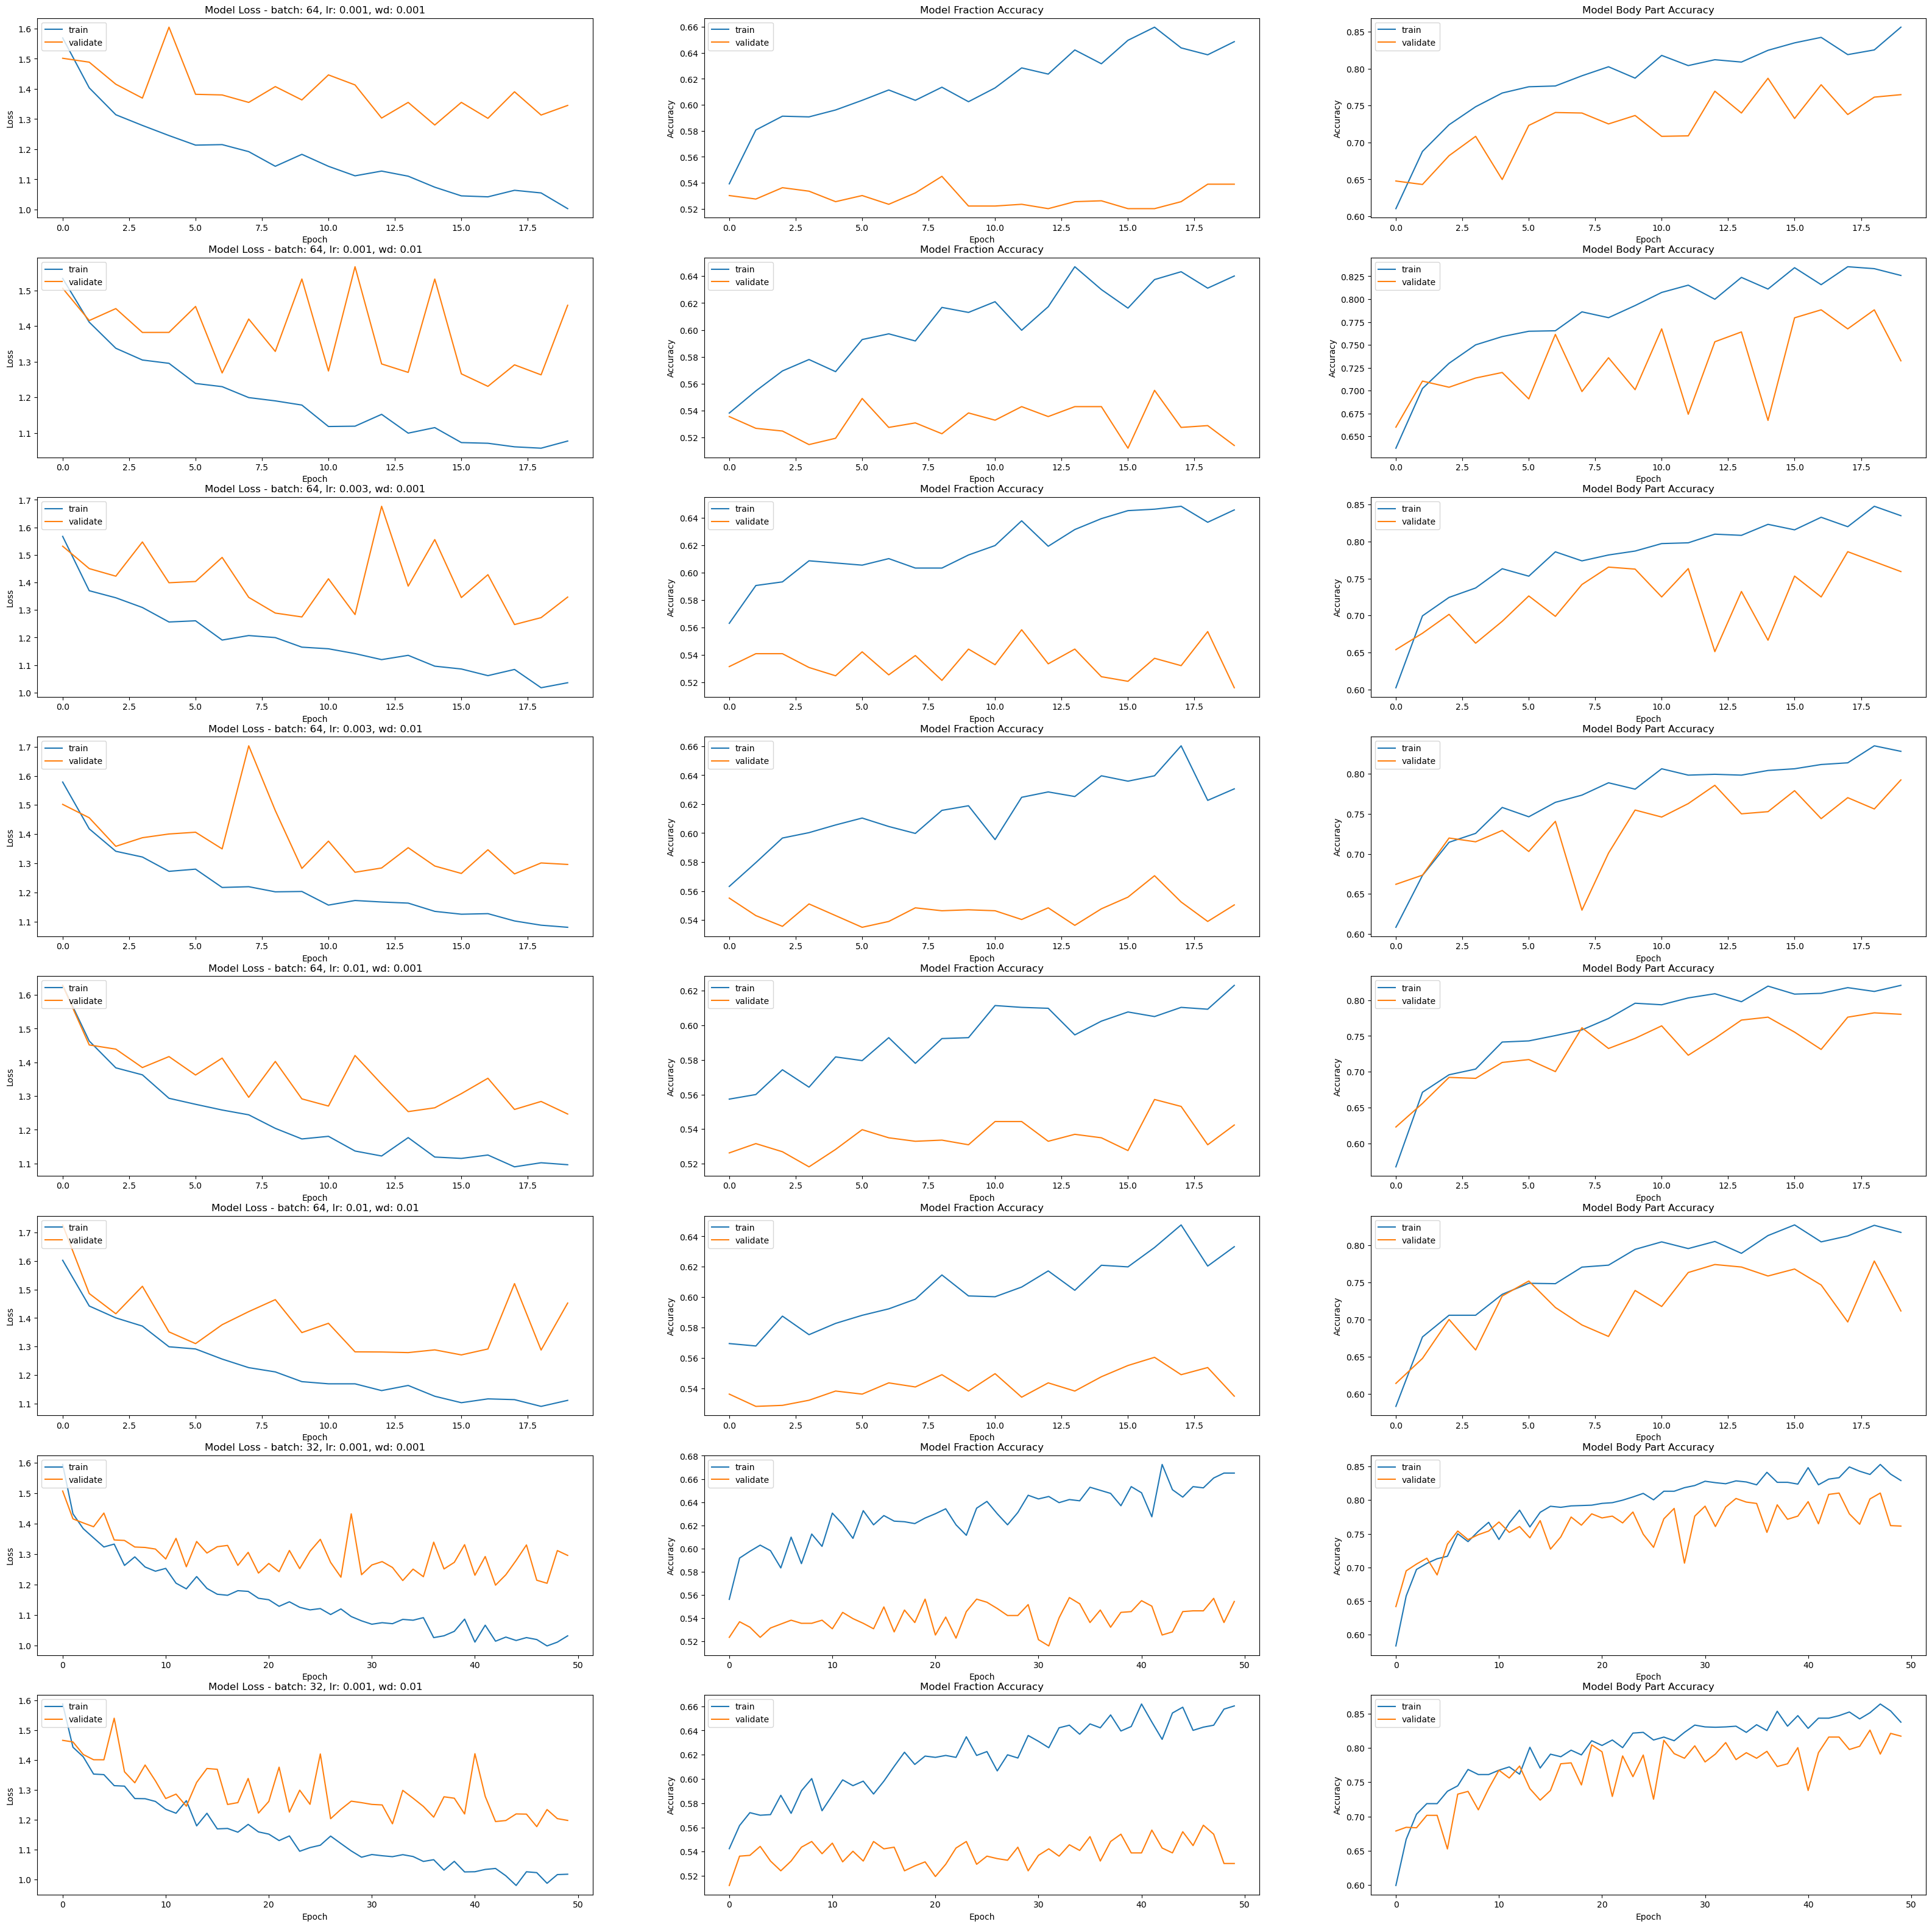

In [ ]:
num_figs = len(results64.keys()) + len(results32.keys())
fig, axs = plt.subplots(num_figs, 3, figsize=(40,40)) 
for i, (key, val) in enumerate(results64.items()):
    batch, learning_rate, weight_decay = key
    losses, fraction_acc, body_part_acc = val

    axs[i, 0].plot(losses['train']) 
    axs[i, 0].plot(losses['val'])
    axs[i, 0].set_title(f'Model Loss - batch: {batch}, lr: {learning_rate}, wd: {weight_decay}')
    axs[i, 0].set_ylabel('Loss') 
    axs[i, 0].set_xlabel('Epoch')
    axs[i, 0].legend(['train', 'validate'], loc='upper left')

    axs[i, 1].plot(fraction_acc['train']) 
    axs[i, 1].plot(fraction_acc['val']) 
    axs[i, 1].set_title('Model Fraction Accuracy')
    axs[i, 1].set_ylabel('Accuracy') 
    axs[i, 1].set_xlabel('Epoch')
    axs[i, 1].legend(['train', 'validate'], loc='upper left')

    axs[i, 2].plot(body_part_acc['train']) 
    axs[i, 2].plot(body_part_acc['val']) 
    axs[i, 2].set_title('Model Body Part Accuracy')
    axs[i, 2].set_ylabel('Accuracy') 
    axs[i, 2].set_xlabel('Epoch')
    axs[i, 2].legend(['train', 'validate'], loc='upper left')

j = len(results64.keys())
for i, (key, val) in enumerate(results32.items()):
    batch, learning_rate, weight_decay = key
    losses, fraction_acc, body_part_acc = val

    i = i + j
    axs[i, 0].plot(losses['train']) 
    axs[i, 0].plot(losses['val'])
    axs[i, 0].set_title(f'Model Loss - batch: {batch}, lr: {learning_rate}, wd: {weight_decay}')
    axs[i, 0].set_ylabel('Loss') 
    axs[i, 0].set_xlabel('Epoch')
    axs[i, 0].legend(['train', 'validate'], loc='upper left')

    axs[i, 1].plot(fraction_acc['train']) 
    axs[i, 1].plot(fraction_acc['val']) 
    axs[i, 1].set_title('Model Fraction Accuracy')
    axs[i, 1].set_ylabel('Accuracy') 
    axs[i, 1].set_xlabel('Epoch')
    axs[i, 1].legend(['train', 'validate'], loc='upper left')

    axs[i, 2].plot(body_part_acc['train']) 
    axs[i, 2].plot(body_part_acc['val']) 
    axs[i, 2].set_title('Model Body Part Accuracy')
    axs[i, 2].set_ylabel('Accuracy') 
    axs[i, 2].set_xlabel('Epoch')
    axs[i, 2].legend(['train', 'validate'], loc='upper left')

plt.show()

# Training Teacher model on 1, 10, 100 percentage. 

Followed the fine-tuning results.

In [ ]:
models = [
    {'name': 'model_1', 'epochs': 12, 'train_dataloader': prepare_train_dataloader(0.01)},
    {'name': 'model_10', 'epochs': 8, 'train_dataloader': prepare_train_dataloader(0.1)},
    {'name': 'model_100', 'epochs': 8, 'train_dataloader': prepare_train_dataloader(1)},
]


models_losses = {}
for model in models:
    train_dataloader = model['train_dataloader']
    val_dataloader = DataLoader(dataset=val_data, batch_size=64, shuffle=True)

    teacher_model = TeacherModel(pretrained_model).to(device)
    hist_losses = teacher_model.train_loop(train_dataloader, val_dataloader, model['epochs'])
    models_losses[model['name']] = hist_losses
    torch.save(teacher_model.state_dict(), f'./fined-tuned-models/v4/{model["name"]}')

  0%|                                    | 0/50 [00:00<?, ?it/s]

  2%|▌                           | 1/50 [00:24<20:08, 24.66s/it]


--------------------- Epoch 1/50  ---------------------
Train: 
Train loss: 1.5226
Train fraction accuracy: 0.5727
Train body part accuracy: 0.6173

Val: 
Val loss: 1.5833
Val fraction accuracy: 0.5289
Val body part accuracy: 0.5894


  4%|█                           | 2/50 [00:49<19:46, 24.71s/it]


--------------------- Epoch 2/50  ---------------------
Train: 
Train loss: 1.3762
Train fraction accuracy: 0.5908
Train body part accuracy: 0.6858

Val: 
Val loss: 1.4986
Val fraction accuracy: 0.5195
Val body part accuracy: 0.6384


  6%|█▋                          | 3/50 [01:14<19:19, 24.68s/it]


--------------------- Epoch 3/50  ---------------------
Train: 
Train loss: 1.3320
Train fraction accuracy: 0.6168
Train body part accuracy: 0.7128

Val: 
Val loss: 1.7894
Val fraction accuracy: 0.5323
Val body part accuracy: 0.6136


  8%|██▏                         | 4/50 [01:38<18:55, 24.69s/it]


--------------------- Epoch 4/50  ---------------------
Train: 
Train loss: 1.2847
Train fraction accuracy: 0.6184
Train body part accuracy: 0.7351

Val: 
Val loss: 1.5191
Val fraction accuracy: 0.5235
Val body part accuracy: 0.6425


 10%|██▊                         | 5/50 [02:03<18:28, 24.64s/it]


--------------------- Epoch 5/50  ---------------------
Train: 
Train loss: 1.2753
Train fraction accuracy: 0.6104
Train body part accuracy: 0.7394

Val: 
Val loss: 1.6798
Val fraction accuracy: 0.5363
Val body part accuracy: 0.5880


 12%|███▎                        | 6/50 [02:28<18:07, 24.71s/it]


--------------------- Epoch 6/50  ---------------------
Train: 
Train loss: 1.2145
Train fraction accuracy: 0.6178
Train body part accuracy: 0.7558

Val: 
Val loss: 1.4935
Val fraction accuracy: 0.5148
Val body part accuracy: 0.6720


 14%|███▉                        | 7/50 [02:52<17:41, 24.69s/it]


--------------------- Epoch 7/50  ---------------------
Train: 
Train loss: 1.2117
Train fraction accuracy: 0.6173
Train body part accuracy: 0.7590

Val: 
Val loss: 1.5655
Val fraction accuracy: 0.5282
Val body part accuracy: 0.6223


 16%|████▍                       | 8/50 [03:17<17:17, 24.69s/it]


--------------------- Epoch 8/50  ---------------------
Train: 
Train loss: 1.1636
Train fraction accuracy: 0.6152
Train body part accuracy: 0.7824

Val: 
Val loss: 1.7441
Val fraction accuracy: 0.5081
Val body part accuracy: 0.5894


 18%|█████                       | 9/50 [03:41<16:41, 24.43s/it]


--------------------- Epoch 9/50  ---------------------
Train: 
Train loss: 1.1796
Train fraction accuracy: 0.6269
Train body part accuracy: 0.7797

Val: 
Val loss: 1.7074
Val fraction accuracy: 0.5531
Val body part accuracy: 0.6519


 20%|█████▍                     | 10/50 [04:05<16:18, 24.46s/it]


--------------------- Epoch 10/50  ---------------------
Train: 
Train loss: 1.1616
Train fraction accuracy: 0.6194
Train body part accuracy: 0.7909

Val: 
Val loss: 1.5395
Val fraction accuracy: 0.5316
Val body part accuracy: 0.6579


 22%|█████▉                     | 11/50 [04:30<15:56, 24.53s/it]


--------------------- Epoch 11/50  ---------------------
Train: 
Train loss: 1.1362
Train fraction accuracy: 0.6269
Train body part accuracy: 0.7845

Val: 
Val loss: 1.5791
Val fraction accuracy: 0.5134
Val body part accuracy: 0.6626


 24%|██████▍                    | 12/50 [04:55<15:32, 24.53s/it]


--------------------- Epoch 12/50  ---------------------
Train: 
Train loss: 1.0999
Train fraction accuracy: 0.6300
Train body part accuracy: 0.8163

Val: 
Val loss: 1.4136
Val fraction accuracy: 0.5168
Val body part accuracy: 0.7285


 26%|███████                    | 13/50 [05:20<15:12, 24.67s/it]


--------------------- Epoch 13/50  ---------------------
Train: 
Train loss: 1.1449
Train fraction accuracy: 0.6316
Train body part accuracy: 0.7887

Val: 
Val loss: 1.5059
Val fraction accuracy: 0.5222
Val body part accuracy: 0.7184


 28%|███████▌                   | 14/50 [05:44<14:45, 24.59s/it]


--------------------- Epoch 14/50  ---------------------
Train: 
Train loss: 1.1035
Train fraction accuracy: 0.6359
Train body part accuracy: 0.8073

Val: 
Val loss: 1.7120
Val fraction accuracy: 0.5155
Val body part accuracy: 0.6169


 30%|████████                   | 15/50 [06:08<14:19, 24.56s/it]


--------------------- Epoch 15/50  ---------------------
Train: 
Train loss: 1.0985
Train fraction accuracy: 0.6507
Train body part accuracy: 0.8010

Val: 
Val loss: 1.6343
Val fraction accuracy: 0.5309
Val body part accuracy: 0.6613


 32%|████████▋                  | 16/50 [06:33<13:56, 24.60s/it]


--------------------- Epoch 16/50  ---------------------
Train: 
Train loss: 1.0731
Train fraction accuracy: 0.6438
Train body part accuracy: 0.8206

Val: 
Val loss: 1.8161
Val fraction accuracy: 0.5181
Val body part accuracy: 0.5981


 34%|█████████▏                 | 17/50 [06:58<13:33, 24.64s/it]


--------------------- Epoch 17/50  ---------------------
Train: 
Train loss: 1.0686
Train fraction accuracy: 0.6555
Train body part accuracy: 0.8153

Val: 
Val loss: 1.3983
Val fraction accuracy: 0.5296
Val body part accuracy: 0.7319


 36%|█████████▋                 | 18/50 [07:22<13:06, 24.56s/it]


--------------------- Epoch 18/50  ---------------------
Train: 
Train loss: 1.0230
Train fraction accuracy: 0.6661
Train body part accuracy: 0.8344

Val: 
Val loss: 1.6375
Val fraction accuracy: 0.5175
Val body part accuracy: 0.6089


 38%|██████████▎                | 19/50 [07:47<12:42, 24.61s/it]


--------------------- Epoch 19/50  ---------------------
Train: 
Train loss: 1.0219
Train fraction accuracy: 0.6704
Train body part accuracy: 0.8328

Val: 
Val loss: 1.8097
Val fraction accuracy: 0.5302
Val body part accuracy: 0.6452


 40%|██████████▊                | 20/50 [08:12<12:17, 24.57s/it]


--------------------- Epoch 20/50  ---------------------
Train: 
Train loss: 1.0184
Train fraction accuracy: 0.6619
Train body part accuracy: 0.8307

Val: 
Val loss: 1.5798
Val fraction accuracy: 0.5188
Val body part accuracy: 0.6956


 42%|███████████▎               | 21/50 [08:36<11:53, 24.61s/it]


--------------------- Epoch 21/50  ---------------------
Train: 
Train loss: 1.0097
Train fraction accuracy: 0.6810
Train body part accuracy: 0.8286

Val: 
Val loss: 2.3073
Val fraction accuracy: 0.5343
Val body part accuracy: 0.5282


 44%|███████████▉               | 22/50 [09:00<11:22, 24.37s/it]


--------------------- Epoch 22/50  ---------------------
Train: 
Train loss: 0.9947
Train fraction accuracy: 0.6906
Train body part accuracy: 0.8344

Val: 
Val loss: 2.1483
Val fraction accuracy: 0.5349
Val body part accuracy: 0.6109


 46%|████████████▍              | 23/50 [09:24<10:58, 24.38s/it]


--------------------- Epoch 23/50  ---------------------
Train: 
Train loss: 0.9635
Train fraction accuracy: 0.6688
Train body part accuracy: 0.8477

Val: 
Val loss: 1.8747
Val fraction accuracy: 0.4751
Val body part accuracy: 0.5759


 48%|████████████▉              | 24/50 [09:49<10:36, 24.47s/it]


--------------------- Epoch 24/50  ---------------------
Train: 
Train loss: 0.9394
Train fraction accuracy: 0.6815
Train body part accuracy: 0.8652

Val: 
Val loss: 1.9439
Val fraction accuracy: 0.5262
Val body part accuracy: 0.6660


 50%|█████████████▌             | 25/50 [10:13<10:10, 24.41s/it]


--------------------- Epoch 25/50  ---------------------
Train: 
Train loss: 0.9339
Train fraction accuracy: 0.7070
Train body part accuracy: 0.8524

Val: 
Val loss: 1.6375
Val fraction accuracy: 0.5242
Val body part accuracy: 0.6667


 52%|██████████████             | 26/50 [10:38<09:47, 24.46s/it]


--------------------- Epoch 26/50  ---------------------
Train: 
Train loss: 0.9962
Train fraction accuracy: 0.6921
Train body part accuracy: 0.8381

Val: 
Val loss: 1.4966
Val fraction accuracy: 0.5309
Val body part accuracy: 0.7191


 54%|██████████████▌            | 27/50 [11:03<09:24, 24.52s/it]


--------------------- Epoch 27/50  ---------------------
Train: 
Train loss: 0.9560
Train fraction accuracy: 0.6874
Train body part accuracy: 0.8556

Val: 
Val loss: 1.4788
Val fraction accuracy: 0.5262
Val body part accuracy: 0.7319


 56%|███████████████            | 28/50 [11:27<09:00, 24.55s/it]


--------------------- Epoch 28/50  ---------------------
Train: 
Train loss: 0.8845
Train fraction accuracy: 0.7171
Train body part accuracy: 0.8678

Val: 
Val loss: 1.8114
Val fraction accuracy: 0.5356
Val body part accuracy: 0.6384


 58%|███████████████▋           | 29/50 [11:52<08:36, 24.59s/it]


--------------------- Epoch 29/50  ---------------------
Train: 
Train loss: 0.8851
Train fraction accuracy: 0.7282
Train body part accuracy: 0.8620

Val: 
Val loss: 1.4330
Val fraction accuracy: 0.5148
Val body part accuracy: 0.7614


 60%|████████████████▏          | 30/50 [12:16<08:10, 24.53s/it]


--------------------- Epoch 30/50  ---------------------
Train: 
Train loss: 0.8719
Train fraction accuracy: 0.7224
Train body part accuracy: 0.8652

Val: 
Val loss: 2.0372
Val fraction accuracy: 0.4973
Val body part accuracy: 0.6116


 62%|████████████████▋          | 31/50 [12:41<07:47, 24.60s/it]


--------------------- Epoch 31/50  ---------------------
Train: 
Train loss: 0.8612
Train fraction accuracy: 0.7357
Train body part accuracy: 0.8737

Val: 
Val loss: 1.8959
Val fraction accuracy: 0.5397
Val body part accuracy: 0.6868


 64%|█████████████████▎         | 32/50 [13:06<07:22, 24.59s/it]


--------------------- Epoch 32/50  ---------------------
Train: 
Train loss: 0.8710
Train fraction accuracy: 0.7102
Train body part accuracy: 0.8827

Val: 
Val loss: 2.0892
Val fraction accuracy: 0.5249
Val body part accuracy: 0.5699


 66%|█████████████████▊         | 33/50 [13:30<06:58, 24.62s/it]


--------------------- Epoch 33/50  ---------------------
Train: 
Train loss: 0.8688
Train fraction accuracy: 0.7235
Train body part accuracy: 0.8657

Val: 
Val loss: 3.1584
Val fraction accuracy: 0.5168
Val body part accuracy: 0.5336


 68%|██████████████████▎        | 34/50 [13:55<06:33, 24.61s/it]


--------------------- Epoch 34/50  ---------------------
Train: 
Train loss: 0.8363
Train fraction accuracy: 0.7383
Train body part accuracy: 0.8705

Val: 
Val loss: 1.8494
Val fraction accuracy: 0.5128
Val body part accuracy: 0.6720


 70%|██████████████████▉        | 35/50 [14:18<06:04, 24.29s/it]


--------------------- Epoch 35/50  ---------------------
Train: 
Train loss: 0.7921
Train fraction accuracy: 0.7495
Train body part accuracy: 0.8822

Val: 
Val loss: 1.9787
Val fraction accuracy: 0.5087
Val body part accuracy: 0.6405


 72%|███████████████████▍       | 36/50 [14:43<05:40, 24.31s/it]


--------------------- Epoch 36/50  ---------------------
Train: 
Train loss: 0.7800
Train fraction accuracy: 0.7611
Train body part accuracy: 0.8907

Val: 
Val loss: 1.6808
Val fraction accuracy: 0.5269
Val body part accuracy: 0.7352


 74%|███████████████████▉       | 37/50 [15:07<05:17, 24.41s/it]


--------------------- Epoch 37/50  ---------------------
Train: 
Train loss: 0.8373
Train fraction accuracy: 0.7431
Train body part accuracy: 0.8700

Val: 
Val loss: 3.7739
Val fraction accuracy: 0.5134
Val body part accuracy: 0.4442


 76%|████████████████████▌      | 38/50 [15:32<04:53, 24.48s/it]


--------------------- Epoch 38/50  ---------------------
Train: 
Train loss: 0.8496
Train fraction accuracy: 0.7479
Train body part accuracy: 0.8763

Val: 
Val loss: 1.8346
Val fraction accuracy: 0.5316
Val body part accuracy: 0.7157


 78%|█████████████████████      | 39/50 [15:57<04:30, 24.61s/it]


--------------------- Epoch 39/50  ---------------------
Train: 
Train loss: 0.7425
Train fraction accuracy: 0.7654
Train body part accuracy: 0.8997

Val: 
Val loss: 1.5620
Val fraction accuracy: 0.5108
Val body part accuracy: 0.7742


 80%|█████████████████████▌     | 40/50 [16:21<04:05, 24.57s/it]


--------------------- Epoch 40/50  ---------------------
Train: 
Train loss: 0.7224
Train fraction accuracy: 0.7643
Train body part accuracy: 0.9050

Val: 
Val loss: 1.7090
Val fraction accuracy: 0.5067
Val body part accuracy: 0.7258


 82%|██████████████████████▏    | 41/50 [16:46<03:40, 24.47s/it]


--------------------- Epoch 41/50  ---------------------
Train: 
Train loss: 0.7437
Train fraction accuracy: 0.7665
Train body part accuracy: 0.8960

Val: 
Val loss: 1.7304
Val fraction accuracy: 0.5141
Val body part accuracy: 0.7413


 84%|██████████████████████▋    | 42/50 [17:10<03:15, 24.44s/it]


--------------------- Epoch 42/50  ---------------------
Train: 
Train loss: 0.7251
Train fraction accuracy: 0.7755
Train body part accuracy: 0.9023

Val: 
Val loss: 1.7560
Val fraction accuracy: 0.5188
Val body part accuracy: 0.7050


 86%|███████████████████████▏   | 43/50 [17:35<02:51, 24.52s/it]


--------------------- Epoch 43/50  ---------------------
Train: 
Train loss: 0.7438
Train fraction accuracy: 0.7988
Train body part accuracy: 0.8923

Val: 
Val loss: 1.7031
Val fraction accuracy: 0.5060
Val body part accuracy: 0.7453


 88%|███████████████████████▊   | 44/50 [17:59<02:26, 24.45s/it]


--------------------- Epoch 44/50  ---------------------
Train: 
Train loss: 0.7401
Train fraction accuracy: 0.7840
Train body part accuracy: 0.8965

Val: 
Val loss: 2.1437
Val fraction accuracy: 0.5148
Val body part accuracy: 0.6478


 90%|████████████████████████▎  | 45/50 [18:24<02:02, 24.52s/it]


--------------------- Epoch 45/50  ---------------------
Train: 
Train loss: 0.6797
Train fraction accuracy: 0.8047
Train body part accuracy: 0.9076

Val: 
Val loss: 2.0080
Val fraction accuracy: 0.5060
Val body part accuracy: 0.6983


 92%|████████████████████████▊  | 46/50 [18:48<01:37, 24.49s/it]


--------------------- Epoch 46/50  ---------------------
Train: 
Train loss: 0.7345
Train fraction accuracy: 0.7781
Train body part accuracy: 0.9013

Val: 
Val loss: 2.8864
Val fraction accuracy: 0.4973
Val body part accuracy: 0.5484


 94%|█████████████████████████▍ | 47/50 [19:12<01:12, 24.32s/it]


--------------------- Epoch 47/50  ---------------------
Train: 
Train loss: 0.7318
Train fraction accuracy: 0.7898
Train body part accuracy: 0.8960

Val: 
Val loss: 2.3534
Val fraction accuracy: 0.5282
Val body part accuracy: 0.6485


 96%|█████████████████████████▉ | 48/50 [19:37<00:48, 24.40s/it]


--------------------- Epoch 48/50  ---------------------
Train: 
Train loss: 0.7056
Train fraction accuracy: 0.7872
Train body part accuracy: 0.9087

Val: 
Val loss: 1.7003
Val fraction accuracy: 0.5202
Val body part accuracy: 0.7245


 98%|██████████████████████████▍| 49/50 [20:01<00:24, 24.40s/it]


--------------------- Epoch 49/50  ---------------------
Train: 
Train loss: 0.6435
Train fraction accuracy: 0.8100
Train body part accuracy: 0.9135

Val: 
Val loss: 2.1040
Val fraction accuracy: 0.5155
Val body part accuracy: 0.6660


100%|███████████████████████████| 50/50 [20:26<00:00, 24.52s/it]


--------------------- Epoch 50/50  ---------------------
Train: 
Train loss: 0.6007
Train fraction accuracy: 0.8307
Train body part accuracy: 0.9236

Val: 
Val loss: 2.2234
Val fraction accuracy: 0.5269
Val body part accuracy: 0.6720


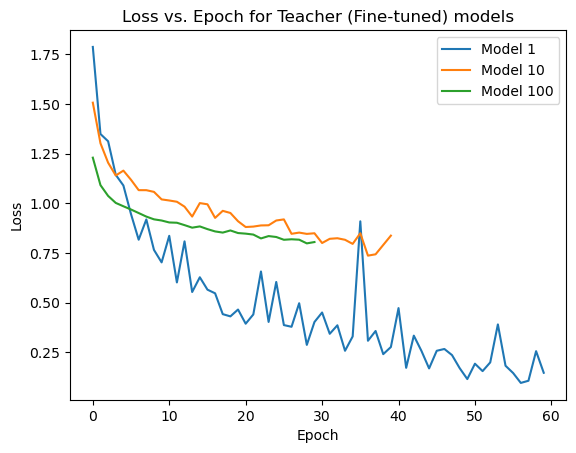

In [ ]:
# Plot loss for each model
for model, losses in models_losses.items():
    plt.plot(losses, label='Model ' + model)

plt.plo
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch for Teacher (Fine-tuned) models')
plt.legend()
plt.show()

# Student Model

In [ ]:
class StudentModel(nn.Module):
    def __init__(self, num_body_parts=3):
        super(StudentModel, self).__init__()
        
        self.resnet = nn.Sequential(*list(resnet50(pretrained=True).children())[:-1])
        self.resnet.requires_grad_(False)

        self.base_model = nn.Sequential(
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
        )

        self.part_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_body_parts, bias=True)
        )

        self.fraction_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2, bias=True)
        )

        # Define Optimizer - combine the parameters of the two parts of the model
        parameters = list(self.base_model.parameters()) + list(self.fraction_classifier.parameters()) + list(self.part_classifier.parameters())
        self.optimizer = AdamW(parameters, lr=0.001, weight_decay=0.01)
        
        # This loss function is suitable for distillation
        self.criterion = nn.KLDivLoss(reduction='batchmean').to(device)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, start_dim=1)
        x = self.base_model(x)
        x_body_part = self.part_classifier(x)
        x_fraction = self.fraction_classifier(x)
        return x_body_part, x_fraction
    
    def train_loop(self, train_dataloader, num_epochs, teacher):
        teacher.eval()
        self.train()

        loss_lst = []
        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            for images, _, _ in train_dataloader:
                images = images.to(device)

                with torch.no_grad():
                    teacher_outputs_parts, teacher_outputs_fraction = teacher(images)
                    # to proability distribution
                    teacher_outputs_parts, teacher_outputs_fraction = F.softmax(teacher_outputs_parts, dim=1), F.softmax(teacher_outputs_fraction, dim=1)

                # Forward pass of the student
                student_outputs_parts, student_outputs_fraction = self.forward(images)
                # to log-proability distribution
                student_outputs_parts, student_outputs_fraction = F.log_softmax(student_outputs_parts, dim=1), F.log_softmax(student_outputs_fraction, dim=1)
    
                # Calculate the loss
                loss_body_parts = self.criterion(student_outputs_parts, teacher_outputs_parts)
                loss_fractions = self.criterion(student_outputs_fraction, teacher_outputs_fraction)

                loss = loss_body_parts + loss_fractions
                running_loss += loss.item()
                
                # Backward and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            epoch_loss = running_loss / len(train_dataloader)
            loss_lst.append(epoch_loss)
            print(f"Epoch {epoch+1} - Loss: {epoch_loss}")

        return loss_lst


In [ ]:
val_data = DefaultDataset(X_val_focused, default_transform)
val_dataloader = DataLoader(dataset=val_data, batch_size=64, shuffle=True)

In [ ]:
teacher = TeacherModel(pretrained_model).to(device)
# teacher.load_state_dict(torch.load("./fined-tuned-models/model_100"))
teacher.load_state_dict(torch.load(f'./fined-tuned-models/v3/model_10'))

<All keys matched successfully>

# Evaluation Metrics

In [ ]:
def evaluate(model, dataloader):
    # Make sure the model is in evaluation mode
    model.eval()

    # We'll store the true and predicted labels here
    true_labels_body_part = []
    pred_labels_body_part = []
    true_labels_fraction = []
    pred_labels_fraction = []

    # We don't need gradients for evaluation, so wrap in no_grad to save memory
    with torch.no_grad():
        for i, (inputs, labels_body_part, labels_fraction) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels_body_part, labels_fraction = labels_body_part.to(device), labels_fraction.to(device)

            # Forward pass and get predictions
            outputs_body_part, outputs_fraction = model(inputs)
            _, predicted_body_part = torch.max(outputs_body_part.data, 1)
            _, predicted_fraction = torch.max(outputs_fraction.data, 1)

            # Store labels and predictions
            true_labels_body_part.extend(labels_body_part.tolist())
            pred_labels_body_part.extend(predicted_body_part.tolist())
            true_labels_fraction.extend(labels_fraction.tolist())
            pred_labels_fraction.extend(predicted_fraction.tolist())

    # Now calculate metrics
    precision_body_part = precision_score(true_labels_body_part, pred_labels_body_part, average='macro')
    recall_body_part = recall_score(true_labels_body_part, pred_labels_body_part, average='macro')
    f1_body_part = f1_score(true_labels_body_part, pred_labels_body_part, average='macro')

    precision_fraction = precision_score(true_labels_fraction, pred_labels_fraction, average='macro')
    recall_fraction = recall_score(true_labels_fraction, pred_labels_fraction, average='macro')
    f1_fraction = f1_score(true_labels_fraction, pred_labels_fraction, average='macro')

    print('Metrics for body part:')
    print(f'Precision: {precision_body_part}')
    print(f'Recall: {recall_body_part}')
    print(f'F1: {f1_body_part}')

    print()

    print('Metrics for fraction:')
    print(f'Precision: {precision_fraction}')
    print(f'Recall: {recall_fraction}')
    print(f'F1: {f1_fraction}')

    # Evaluate fraction success per body part
    unique_body_parts = set(true_labels_body_part) 
    for part in unique_body_parts:
        indices = [i for i, x in enumerate(true_labels_body_part) if x == part]
        part_true_labels_fraction = [true_labels_fraction[i] for i in indices]
        part_pred_labels_fraction = [pred_labels_fraction[i] for i in indices]
        
        accuracy = sum(t==p for t, p in zip(part_true_labels_fraction, part_pred_labels_fraction)) / len(indices)
        part_name = ''
        for body_part in BodyPart:
            if body_part.value == part:
                part_name = body_part.name
        
        print(f'Fraction accuracy for {part_name} body part: {accuracy}')

# Evaluate Teacher Models

In [ ]:
os.listdir('./pretrained-simclr-models/')


In [ ]:
pretrained_model = SimCLR().to(device)
pretrained_model.load_state_dict(torch.load('./pretrained-simclr-models/model_4e'))

<All keys matched successfully>

In [ ]:
model_names = ['1', '10', '100']
for i, model_name in enumerate(model_names):
    teacher = TeacherModel(pretrained_model).to(device)
    teacher.load_state_dict(torch.load(f"./fined-tuned-models/model_{model_name}"))
    
    print(f'Evaluation for TeacherModel {model_name}')
    print()
    evaluate(teacher, val_dataloader)
    print()
    print('---------------------------------')
    print()

Evaluation for TeacherModel 1

Metrics for body part:
Precision: 0.7170330925547191
Recall: 0.707144377542889
F1: 0.7072442641782466

Metrics for fraction:
Precision: 0.5099699520558538
Recall: 0.5098217573236936
F1: 0.5091916167528079
Fraction accuracy for ELBOW body part: 0.4967741935483871
Fraction accuracy for HAND body part: 0.55
Fraction accuracy for SHOULDER body part: 0.4991119005328597

---------------------------------

Evaluation for TeacherModel 10

Metrics for body part:
Precision: 0.8608985121030198
Recall: 0.8570880634283213
F1: 0.8584355180769173

Metrics for fraction:
Precision: 0.5765466711135199
Recall: 0.5532859809151375
F1: 0.5254057599266869
Fraction accuracy for ELBOW body part: 0.6129032258064516
Fraction accuracy for HAND body part: 0.5869565217391305
Fraction accuracy for SHOULDER body part: 0.522202486678508

---------------------------------

Evaluation for TeacherModel 100

Metrics for body part:
Precision: 0.9213280735204096
Recall: 0.9200519628838916
F1: 

In [ ]:
model_names = ['1', '10', '100']
for i, model_name in enumerate(model_names):
    teacher = TeacherModel(pretrained_model).to(device)
    teacher.load_state_dict(torch.load(f"./fined-tuned-models/model_{model_name}"))
    
    print(f'Evaluation for TeacherModel {model_name}')
    print()
    evaluate(teacher, val_dataloader)
    print()
    print('---------------------------------')
    print()

Evaluation for TeacherModel 1

Metrics for body part:
Precision: 0.7197152236199867
Recall: 0.7122090495079815
F1: 0.711961987157864

Metrics for fraction:
Precision: 0.5006790277431336
Recall: 0.5006665735579792
F1: 0.49973597420038557
Fraction accuracy for ELBOW body part: 0.4860215053763441
Fraction accuracy for HAND body part: 0.5347826086956522
Fraction accuracy for SHOULDER body part: 0.49733570159857904

---------------------------------

Evaluation for TeacherModel 10

Metrics for body part:
Precision: 0.8626579282745753
Recall: 0.8572979992365971
F1: 0.8591356928785979

Metrics for fraction:
Precision: 0.5969145452936492
Recall: 0.5655518412847548
F1: 0.5367186244576572
Fraction accuracy for ELBOW body part: 0.6301075268817204
Fraction accuracy for HAND body part: 0.5956521739130435
Fraction accuracy for SHOULDER body part: 0.5346358792184724

---------------------------------

Evaluation for TeacherModel 100

Metrics for body part:
Precision: 0.9132463556233579
Recall: 0.9119

In [ ]:
# v2
teacher = TeacherModel(pretrained_model).to(device)
teacher.load_state_dict(torch.load(f"./fined-tuned-models/v3/model_10"))

print(f'Evaluation for TeacherModel model_10')
print()
evaluate(teacher, val_dataloader)
print()
print('---------------------------------')
print()

Evaluation for TeacherModel model_10

Metrics for body part:
Precision: 0.8149220806692158
Recall: 0.8118112246804462
F1: 0.8127919011614568

Metrics for fraction:
Precision: 0.5508773053278688
Recall: 0.5461141935729612
F1: 0.5395934003743851
Fraction accuracy for ELBOW body part: 0.5720430107526882
Fraction accuracy for HAND body part: 0.5695652173913044
Fraction accuracy for SHOULDER body part: 0.5310834813499112

---------------------------------



# Teach Student

In [ ]:
model_names = ['1', '10', '101']
model_losses_lst = {}
for model_name in model_names:
    teacher = TeacherModel(pretrained_model).to(device)
    teacher.load_state_dict(torch.load(f'./fined-tuned-models/model_{model_name}'))

    student = StudentModel(3).to(device)
    
    train_data = DefaultDataset(X_train_focused, default_transform)
    train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

    hist_losses = student.train_loop(train_dataloader, 30, teacher)
    torch.save(student.state_dict(), f'./student-models/model_{model_name}')

    model_losses_lst[model_name] = hist_losses

  3%|█                             | 1/30 [03:25<1:39:21, 205.56s/it]

Epoch 1 - Loss: 0.6785706175585925


  7%|██                            | 2/30 [06:54<1:36:54, 207.67s/it]

Epoch 2 - Loss: 0.6268893797518843


 10%|███                           | 3/30 [10:20<1:33:02, 206.77s/it]

Epoch 3 - Loss: 0.6002159950086626


 13%|████                          | 4/30 [13:50<1:30:05, 207.92s/it]

Epoch 4 - Loss: 0.5818138993392556


 17%|█████                         | 5/30 [17:15<1:26:15, 207.01s/it]

Epoch 5 - Loss: 0.5672357065192724


 20%|██████                        | 6/30 [20:40<1:22:32, 206.37s/it]

Epoch 6 - Loss: 0.5524593424999108


 23%|███████                       | 7/30 [24:05<1:18:58, 206.01s/it]

Epoch 7 - Loss: 0.5383088392726446


 27%|████████                      | 8/30 [27:32<1:15:35, 206.17s/it]

Epoch 8 - Loss: 0.5234174284894587


 30%|█████████                     | 9/30 [30:38<1:09:57, 199.89s/it]

Epoch 9 - Loss: 0.5070908969741756


 33%|█████████▋                   | 10/30 [33:40<1:04:49, 194.49s/it]

Epoch 10 - Loss: 0.4951534278311972


 37%|██████████▋                  | 11/30 [36:46<1:00:42, 191.73s/it]

Epoch 11 - Loss: 0.47283225332276296


 40%|████████████▍                  | 12/30 [39:51<56:53, 189.66s/it]

Epoch 12 - Loss: 0.460953250173795


 43%|█████████████▍                 | 13/30 [42:53<53:07, 187.50s/it]

Epoch 13 - Loss: 0.44613444896067606


 47%|██████████████▍                | 14/30 [45:56<49:35, 185.95s/it]

Epoch 14 - Loss: 0.433996662447008


 50%|███████████████▌               | 15/30 [49:00<46:21, 185.42s/it]

Epoch 15 - Loss: 0.41661194926601347


 53%|████████████████▌              | 16/30 [52:04<43:10, 185.06s/it]

Epoch 16 - Loss: 0.400455262802415


 57%|█████████████████▌             | 17/30 [55:07<39:57, 184.39s/it]

Epoch 17 - Loss: 0.38083942471924476


 60%|██████████████████▌            | 18/30 [58:10<36:48, 184.07s/it]

Epoch 18 - Loss: 0.371172935124171


 63%|██████████████████▎          | 19/30 [1:01:13<33:38, 183.54s/it]

Epoch 19 - Loss: 0.35722864952127814


 67%|███████████████████▎         | 20/30 [1:04:16<30:34, 183.44s/it]

Epoch 20 - Loss: 0.3422773881483886


 70%|████████████████████▎        | 21/30 [1:07:18<27:27, 183.08s/it]

Epoch 21 - Loss: 0.3297518469519534


 73%|█████████████████████▎       | 22/30 [1:10:21<24:25, 183.14s/it]

Epoch 22 - Loss: 0.32006294242406297


 77%|██████████████████████▏      | 23/30 [1:13:25<21:24, 183.46s/it]

Epoch 23 - Loss: 0.30506933472924314


 80%|███████████████████████▏     | 24/30 [1:16:28<18:18, 183.05s/it]

Epoch 24 - Loss: 0.2889911357123973


 83%|████████████████████████▏    | 25/30 [1:19:31<15:16, 183.22s/it]

Epoch 25 - Loss: 0.28522498415688335


 87%|█████████████████████████▏   | 26/30 [1:22:35<12:14, 183.51s/it]

Epoch 26 - Loss: 0.27634671724448767


 90%|██████████████████████████   | 27/30 [1:25:39<09:10, 183.59s/it]

Epoch 27 - Loss: 0.26760999727047097


 93%|███████████████████████████  | 28/30 [1:28:41<06:05, 182.97s/it]

Epoch 28 - Loss: 0.2615513531333309


 97%|████████████████████████████ | 29/30 [1:31:42<03:02, 182.53s/it]

Epoch 29 - Loss: 0.25250334264868396


100%|█████████████████████████████| 30/30 [1:34:46<00:00, 189.56s/it]

Epoch 30 - Loss: 0.24841064830957832



  3%|█                             | 1/30 [03:00<1:27:05, 180.19s/it]

Epoch 1 - Loss: 0.6810608871912552


  7%|██                            | 2/30 [06:01<1:24:27, 180.99s/it]

Epoch 2 - Loss: 0.6249865336943481


 10%|███                           | 3/30 [09:02<1:21:22, 180.82s/it]

Epoch 3 - Loss: 0.5999341013067859


 13%|████                          | 4/30 [12:04<1:18:30, 181.19s/it]

Epoch 4 - Loss: 0.5843711245868166


 17%|█████                         | 5/30 [15:06<1:15:41, 181.66s/it]

Epoch 5 - Loss: 0.5634327348005974


 20%|██████                        | 6/30 [18:08<1:12:40, 181.69s/it]

Epoch 6 - Loss: 0.554235353813333


 23%|███████                       | 7/30 [21:11<1:09:47, 182.04s/it]

Epoch 7 - Loss: 0.541253620184074


 27%|████████                      | 8/30 [24:14<1:06:52, 182.39s/it]

Epoch 8 - Loss: 0.5209298683425128


 30%|█████████                     | 9/30 [27:18<1:04:02, 182.97s/it]

Epoch 9 - Loss: 0.5075832901364666


 33%|█████████▋                   | 10/30 [30:21<1:00:59, 182.99s/it]

Epoch 10 - Loss: 0.4906949800960088


 37%|███████████▎                   | 11/30 [33:26<58:09, 183.64s/it]

Epoch 11 - Loss: 0.47674575033834427


 40%|████████████▍                  | 12/30 [36:29<55:01, 183.44s/it]

Epoch 12 - Loss: 0.46160261873471536


 43%|█████████████▍                 | 13/30 [39:31<51:49, 182.89s/it]

Epoch 13 - Loss: 0.4459636199272285


 47%|██████████████▍                | 14/30 [42:31<48:32, 182.05s/it]

Epoch 14 - Loss: 0.4259351085808318


 50%|███████████████▌               | 15/30 [45:32<45:24, 181.63s/it]

Epoch 15 - Loss: 0.41420583896717783


 53%|████████████████▌              | 16/30 [48:34<42:27, 181.95s/it]

Epoch 16 - Loss: 0.3985847705501621


 57%|█████████████████▌             | 17/30 [51:35<39:19, 181.53s/it]

Epoch 17 - Loss: 0.38608453374798013


 60%|██████████████████▌            | 18/30 [54:36<36:17, 181.45s/it]

Epoch 18 - Loss: 0.37167951500011703


 63%|███████████████████▋           | 19/30 [57:36<33:10, 180.97s/it]

Epoch 19 - Loss: 0.3574976134098182


 67%|███████████████████▎         | 20/30 [1:00:36<30:07, 180.75s/it]

Epoch 20 - Loss: 0.3440634076373052


 70%|████████████████████▎        | 21/30 [1:03:38<27:10, 181.20s/it]

Epoch 21 - Loss: 0.32741892080185775


 73%|█████████████████████▎       | 22/30 [1:06:38<24:06, 180.86s/it]

Epoch 22 - Loss: 0.3187109221341246


 77%|██████████████████████▏      | 23/30 [1:09:39<21:05, 180.78s/it]

Epoch 23 - Loss: 0.306318107297865


 80%|███████████████████████▏     | 24/30 [1:12:39<18:02, 180.49s/it]

Epoch 24 - Loss: 0.2990203977641413


 83%|████████████████████████▏    | 25/30 [1:15:39<15:02, 180.51s/it]

Epoch 25 - Loss: 0.28705836140503316


 87%|█████████████████████████▏   | 26/30 [1:18:41<12:03, 180.88s/it]

Epoch 26 - Loss: 0.2784172480389223


 90%|██████████████████████████   | 27/30 [1:21:42<09:02, 180.78s/it]

Epoch 27 - Loss: 0.26873788409313915


 93%|███████████████████████████  | 28/30 [1:24:43<06:01, 180.90s/it]

Epoch 28 - Loss: 0.26119789157883594


 97%|████████████████████████████ | 29/30 [1:27:43<03:00, 180.69s/it]

Epoch 29 - Loss: 0.2531616308426453


100%|█████████████████████████████| 30/30 [1:30:42<00:00, 181.40s/it]

Epoch 30 - Loss: 0.24515910118313158



  3%|█                             | 1/30 [03:00<1:27:24, 180.86s/it]

Epoch 1 - Loss: 0.6789036523487608


  7%|██                            | 2/30 [06:05<1:25:22, 182.94s/it]

Epoch 2 - Loss: 0.6199271122277793


 10%|███                           | 3/30 [09:04<1:21:37, 181.38s/it]

Epoch 3 - Loss: 0.6003327477786501


 13%|████                          | 4/30 [12:05<1:18:32, 181.24s/it]

Epoch 4 - Loss: 0.5845447072538279


 17%|█████                         | 5/30 [15:07<1:15:31, 181.27s/it]

Epoch 5 - Loss: 0.5628581121816474


 17%|█████                         | 5/30 [16:36<1:23:03, 199.34s/it]


KeyboardInterrupt: 

In [ ]:
model_losses_lst.keys()

dict_keys(['1', '10'])

# Eval Student

In [ ]:
os.listdir('./student-models')

['model_202_checkpoint', 'model_100', 'model_1']

In [ ]:
model_names = ['1', '10', '100']
for i, model_name in enumerate(model_names):
    student = StudentModel(3).to(device)
    student.load_state_dict(torch.load(f"./student-models/model_{model_name}"))
    
    print(f'Evaluation for StudentModel {model_name}')
    print()
    evaluate(student, val_dataloader)
    print()
    print('---------------------------------')
    print()

Evaluation for StudentModel 1

Metrics for body part:
Precision: 0.7823824323824323
Recall: 0.7721192264884765
F1: 0.7741875928188593

Metrics for fraction:
Precision: 0.5080645161290323
Recall: 0.5075907764357632
F1: 0.5032777663315362
Fraction accuracy for ELBOW body part: 0.4860215053763441
Fraction accuracy for HAND body part: 0.5369565217391304
Fraction accuracy for SHOULDER body part: 0.522202486678508

---------------------------------



FileNotFoundError: [Errno 2] No such file or directory: './student-models/model_10'

In [ ]:
model_name = '100'
student = StudentModel(3).to(device)
student.load_state_dict(torch.load(f"./student-models/model_{model_name}"))

print(f'Evaluation for StudentModel {model_name}')
print()
evaluate(student, val_dataloader)
print()
print('---------------------------------')
print()

Evaluation for StudentModel 100

Metrics for body part:
Precision: 0.9652931484736739
Recall: 0.961142831914893
F1: 0.9625525038025038

Metrics for fraction:
Precision: 0.6433783869534869
Recall: 0.6352436938513804
F1: 0.6337220600728098
Fraction accuracy for ELBOW body part: 0.6795698924731183
Fraction accuracy for HAND body part: 0.6282608695652174
Fraction accuracy for SHOULDER body part: 0.6234458259325044

---------------------------------

